**Air Quality of Altamura - Final Project - Machine Learning for Data Science**

**STUDENT:** Chiara Zandomeneghi - VR513170


Air Quality Analysis – Altamura Station (2016–2020)

Data Source:
The datasets were downloaded from the official ARPA Puglia website:
https://www.arpa.puglia.it/pagina3139_dati-storici-qualit-delllaria.html

For this analysis, I selected the historical air quality datasets
for the Altamura monitoring station covering the period
from January 1, 2016 to December 31, 2020 (inclusive).

All yearly datasets (2016, 2017, 2018, 2019, 2020) were combined
into a single unified pandas DataFrame to allow time-series
analysis, trend evaluation, seasonal decomposition, and
pollutant comparison across the full 5-year period.

After merging, the resulting DataFrame contains 60,666 rows
and 8 columns, structured as follows:

------------------------------------------------------------------
COLUMN DESCRIPTIONS
------------------------------------------------------------------

1. DateTime
   - Type: datetime
   - Description: Timestamp of the measurement.
   - Frequency: Hourly observations.
   - Represents the exact date and hour when pollutant
     concentrations were recorded.

2. NO
   - Nitric Oxide concentration.
   - Unit: µg/m³ (micrograms per cubic meter).
   - Emitted mainly from combustion processes such as
     vehicle traffic and industrial activity.
   - Precursor in the formation of NO₂ and ozone (O₃).

3. NO2
   - Nitrogen Dioxide concentration.
   - Unit: µg/m³.
   - A key air pollutant primarily produced by traffic
     and fuel combustion.
   - Associated with respiratory problems and
     regulatory air quality limits.

4. NOX
   - Nitrogen Oxides (total).
   - Unit: µg/m³.
   - Represents the combined concentration of nitrogen oxides
     (typically NO + NO₂).
   - Important for evaluating traffic-related pollution
     and atmospheric chemistry processes.

5. O3
   - Ozone concentration.
   - Unit: µg/m³.
   - Secondary pollutant formed by photochemical reactions
     between NOx and volatile organic compounds (VOCs)
     under sunlight.
   - Typically higher during warm and sunny periods.

6. PM10
   - Particulate Matter with diameter ≤ 10 micrometers.
   - Unit: µg/m³.
   - Includes dust, pollen, and combustion particles.
   - Can penetrate the respiratory tract.

7. PM2.5
   - Particulate Matter with diameter ≤ 2.5 micrometers.
   - Unit: µg/m³.
   - Finer particles that can reach deep into the lungs
     and bloodstream.
   - More harmful than PM10 due to smaller size.

8. AQ
   - Air Quality Index  
   - Unit: Index value (dimensionless).
   - Represents an aggregated air quality measure derived
     from pollutant concentrations.
   - Higher values typically indicate worse air quality.

------------------------------------------------------------------

Notes:
- Missing values are represented as NaN.  

In this section, we will:
- Load and explore the dataset
- Clean the data by removing unnecessary columns and handling missing values
- Analyze correlations and mutual information between pollutants
- Visualize trends and distributions through various plots (time series decomposition, histograms, boxplots, etc.)

First of all, import libraries

In [1]:
#import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import skew
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
#LOAD DATASET
#load the dataset from CSV file
aq_df = pd.read_csv('_Altamura_2016_2020_with_aq.csv')
aq_df

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016-01-01 01:00:00.000,10.446555,25.236488,41.255988,38.497517,NaN,NaN,NaN
1,2016-01-01 02:00:00.000,11.190016,29.566211,46.724116,36.357080,44.688599,NaN,41.378332
2,2016-01-01 03:00:00.000,10.596083,22.026813,38.278240,42.561329,NaN,NaN,NaN
3,2016-01-01 04:00:00.000,7.879057,14.952126,27.037399,46.502254,81.074501,NaN,63.905561
4,2016-01-01 05:00:00.000,7.716848,17.829514,29.663722,45.634229,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
60661,2020-12-31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.600000,16.4,60.042918
60662,2020-12-31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60663,2020-12-31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918
60664,2021-01-01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.600000,16.4,60.042918


In [3]:
# Create the "DateTime" column as unique format, to create in the future a correct time series analysis
# Replace in the datetime column
datetime_col = 'DateTime'

aq_df[datetime_col] = aq_df[datetime_col].str.replace('-', '/', regex=False)

# Optional: remove milliseconds (.000 .sss etc)
aq_df[datetime_col] = aq_df[datetime_col].str.replace(r'\.\d{1,3}$', '', regex=True)

# Optional: remove any trailing .000000 or similar
aq_df[datetime_col] = aq_df[datetime_col].str.replace(r'\.0+$', '', regex=True)

aq_df[datetime_col] = pd.to_datetime(aq_df[datetime_col], errors='coerce')
# Then format exactly as you want when saving/displaying:
aq_df[datetime_col] = aq_df[datetime_col].dt.strftime('%Y/%m/%d %H:%M:%S')

# Drop duplicate format DateTime
aq_df = aq_df.drop_duplicates(subset=[datetime_col], keep='first')

In [4]:
#show dataframe info
aq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43123 entries, 0 to 60664
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  43123 non-null  object 
 1   NO        39625 non-null  float64
 2   NO2       39614 non-null  float64
 3   NOX       39641 non-null  float64
 4   O3        38424 non-null  float64
 5   PM10      36399 non-null  float64
 6   PM2.5     33572 non-null  float64
 7   AQ        36772 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.0+ MB


In [5]:
# show dataframe statistics
aq_df.describe()

,NO,NO2,NOX,O3,PM10,PM2.5,AQ
count,39625.000000,39614.000000,39641.000000,38424.000000,36399.000000,33572.000000,36772.000000
mean,8.968269,24.036249,37.651555,66.344542,19.672923,12.045579,43.977574
std,12.444314,17.319072,33.529158,26.283865,9.594425,5.172709,17.002448
min,0.000000,0.009734,0.162730,0.000000,0.000000,3.100000,0.000000
25%,2.517036,11.321420,16.416516,48.908781,13.600000,8.100000,31.250000
50%,5.667613,20.222813,29.401760,66.391817,18.100000,11.200000,44.166667
75%,11.177370,32.366235,48.283122,83.632497,23.500000,14.900000,56.257512
max,411.701412,178.542330,796.962688,170.492181,323.565002,35.000000,184.936213


In [6]:
# Show first 10 rows of dataframe
aq_df.head(10)

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016/01/01 01:00:00,10.446555,25.236488,41.255988,38.497517,NaN,NaN,NaN
1,2016/01/01 02:00:00,11.190016,29.566211,46.724116,36.357080,44.688599,NaN,41.378332
2,2016/01/01 03:00:00,10.596083,22.026813,38.278240,42.561329,NaN,NaN,NaN
3,2016/01/01 04:00:00,7.879057,14.952126,27.037399,46.502254,81.074501,NaN,63.905561
4,2016/01/01 05:00:00,7.716848,17.829514,29.663722,45.634229,NaN,NaN,NaN
5,2016/01/01 06:00:00,5.839177,9.545851,18.503284,53.661112,52.258900,NaN,48.387870
6,2016/01/01 07:00:00,5.733145,8.630194,17.425509,53.239767,NaN,NaN,NaN
7,2016/01/01 08:00:00,13.371830,18.135166,38.650507,46.216768,40.048801,NaN,37.082223
8,2016/01/01 09:00:00,5.823116,7.689242,16.623329,59.337483,NaN,NaN,NaN
9,2016/01/01 10:00:00,4.620896,5.567878,12.657822,67.102423,24.908400,NaN,23.063333


In [7]:
# show last 10 rows of dataframe *
aq_df.tail(10)

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
60646,2020/12/31 15:00:00,2.806022,9.875812,14.219398,66.720042,19.6,16.4,60.042918
60648,2020/12/31 16:00:00,3.174665,14.367886,19.295426,59.566592,19.6,16.4,60.042918
60650,2020/12/31 17:00:00,9.531216,34.103292,48.859456,33.269976,19.6,16.4,60.042918
60652,2020/12/31 18:00:00,12.813324,44.166510,63.997047,19.907761,19.6,16.4,60.042918
60654,2020/12/31 19:00:00,25.256314,56.283484,95.243124,10.187630,19.6,16.4,60.042918
60656,2020/12/31 20:00:00,10.434137,41.507723,57.679207,25.414405,19.6,16.4,60.042918
60658,2020/12/31 21:00:00,8.277063,46.720254,59.606082,19.897200,19.6,16.4,60.042918
60660,2020/12/31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.6,16.4,60.042918
60662,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.6,16.4,60.042918
60664,2021/01/01 00:00:00,2.495988,22.675000,26.596570,38.168679,19.6,16.4,60.042918


In [8]:
#DATA CLEANING
pollutants = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']

# replace NaN values with the nearest value
aq_df.bfill(inplace=True)
aq_df

,DateTime,NO,NO2,NOX,O3,PM10,PM2.5,AQ
0,2016/01/01 01:00:00,10.446555,25.236488,41.255988,38.497517,44.688599,9.4,41.378332
1,2016/01/01 02:00:00,11.190016,29.566211,46.724116,36.357080,44.688599,9.4,41.378332
2,2016/01/01 03:00:00,10.596083,22.026813,38.278240,42.561329,81.074501,9.4,63.905561
3,2016/01/01 04:00:00,7.879057,14.952126,27.037399,46.502254,81.074501,9.4,63.905561
4,2016/01/01 05:00:00,7.716848,17.829514,29.663722,45.634229,52.258900,9.4,48.387870
...,...,...,...,...,...,...,...,...
60656,2020/12/31 20:00:00,10.434137,41.507723,57.679207,25.414405,19.600000,16.4,60.042918
60658,2020/12/31 21:00:00,8.277063,46.720254,59.606082,19.897200,19.600000,16.4,60.042918
60660,2020/12/31 22:00:00,5.468918,39.521404,48.071521,24.637252,19.600000,16.4,60.042918
60662,2020/12/31 23:00:00,4.187586,32.186358,38.741288,29.842506,19.600000,16.4,60.042918


In [9]:
# verify if I have toher missing values
aq_df.isna().sum()

,0
DateTime,0
NO,0
NO2,0
NOX,0
O3,0
PM10,0
PM2.5,0
AQ,0


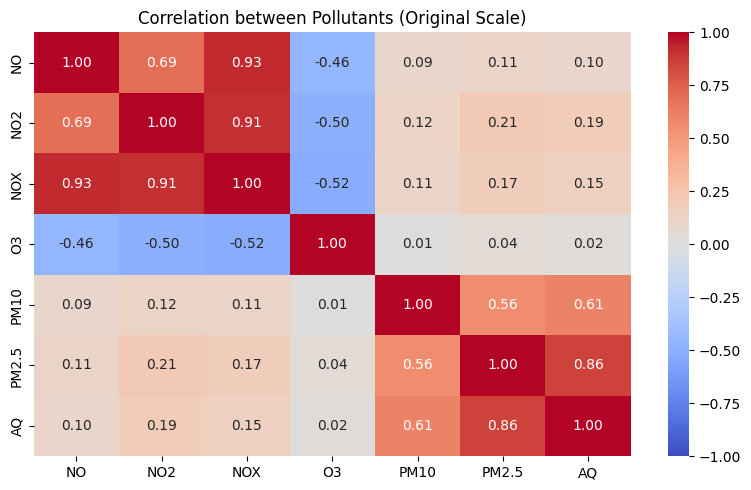

In [10]:
# Calculate correlation matrix - Traditional
aq_correlation_matrix = aq_df[['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']].corr()

# Visualize correlation matrix with .4f formatting
plt.figure(figsize=(8, 5))
sns.heatmap(aq_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation between Pollutants (Original Scale)')
plt.tight_layout()
plt.show()

The strongest linear relationships are observed within the nitrogen oxides group (NO–NO₂–NOx: r = 0.70–0.93), reflecting their direct chemical and definitional linkage (NOx ≈ NO + NO₂). PM₂.₅ shows a very strong positive association with the overall Air Quality index (r = 0.89), indicating it as the primary driver of AQ variation in this dataset, while PM₁₀ exhibits a more moderate link (r = 0.65). A clear antagonistic pattern appears between NOx species and ozone (r ≈ –0.47 to –0.53), consistent with urban NOx titration of O₃. Notably, ozone shows near-zero correlation with particulate matter fractions and AQ (r ≈ 0.03–0.04), and traffic-related NOx displays only weak positive associations with PM levels (r = 0.10–0.22), suggesting dominant influence from secondary formation processes, long-range transport, or non-traffic sources for particulate pollution in this monitoring context.

To understand better, try to see the non-linear correlation map.

In [11]:
!pip install dcor

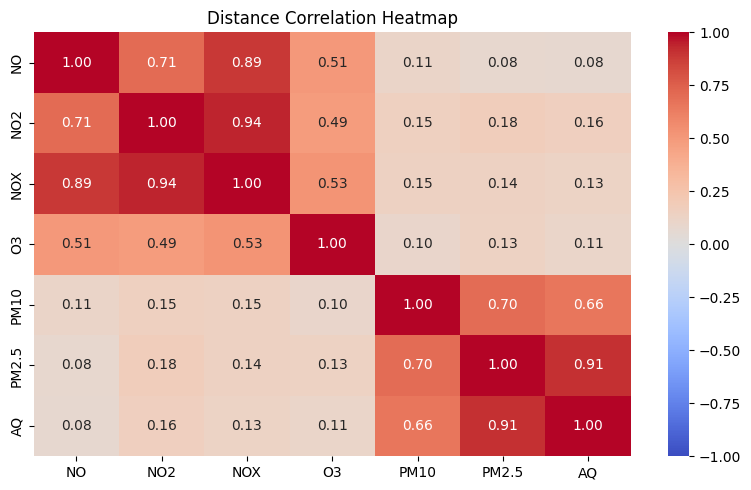

In [12]:
# Distance Correlation (dCor) — Best for general non-linear
import dcor

pollutants = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']

n = len(pollutants)
dist_corr_matrix = np.zeros((n, n))

# Compute distance correlation matrix
for i in range(n):
    for j in range(n):
        x = aq_df[pollutants[i]].values
        y = aq_df[pollutants[j]].values
        dist_corr_matrix[i, j] = dcor.distance_correlation(x, y)

# Plot heatmap with values
plt.figure(figsize=(8, 5))
sns.heatmap(dist_corr_matrix, annot=True, xticklabels=pollutants, yticklabels=pollutants, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Distance Correlation Heatmap")
plt.tight_layout()
plt.show()

Distance correlation captures any form of dependence (linear or nonlinear), unlike previous r which is limited to linear relationships. The nitrogen oxides group exhibits very strong dependence (NO–NO₂–NOx: dCor = 0.73–0.95), consistent with their tight chemical linkage and near-deterministic definition (NOx ≈ NO + NO₂). PM₂.₅ shows extremely strong overall dependence with AQ (dCor = 0.93), confirming it as the dominant contributor to air quality variation, while PM₁₀ is also strongly linked (dCor = 0.71–0.75 with PM₂.₅ and AQ). Notably, the NOx group displays moderate-to-moderate-strong dependence with O₃ (dCor ≈ 0.50–0.53), higher than the linear values (previously –0.47 to –0.53), suggesting additional nonlinear antagonistic patterns (e.g., threshold or titration effects in urban ozone chemistry). Ozone exhibits low-to-moderate dependence with other variables (dCor ≈ 0.11–0.15 with PM fractions, 0.13 with AQ), indicating mostly independent behavior or weak/complex associations beyond simple linearity. Traffic-related NOx shows only weak dependence with particulate matter (dCor = 0.09–0.18), reinforcing that PM levels are likely driven more by nonlinear secondary formation, long-range transport, or non-traffic sources in this dataset. Overall, the elevated dCor values (compared to linear) for NOx–O₃ and within PM/AQ groups highlight the presence of nonlinear dependencies that linear correlation underestimates in this air quality context.

**Overall conclusion:**

Nitrogen oxides (NO, NO₂, NOx) are tightly linked both linearly and nonlinearly due to their chemical definition. PM₂.₅ dominates the Air Quality index (strong linear and overall dependence), while PM₁₀ plays a secondary role.
The NOx–O₃ relationship shows clear antagonism linearly, but distance correlation reveals stronger (nonlinear) dependence, pointing to complex photochemical and titration effects.
O₃ is largely independent of PM and AQ, and NOx has only weak links to particulates in both metrics — indicating that PM pollution here stems mainly from secondary formation, long-range transport, or non-traffic sources rather than direct vehicle emissions.
Linear correlation captures the main patterns effectively, but distance correlation adds important nonlinear insights, especially for NOx–O₃ interactions, improving our understanding of urban air quality dynamics.

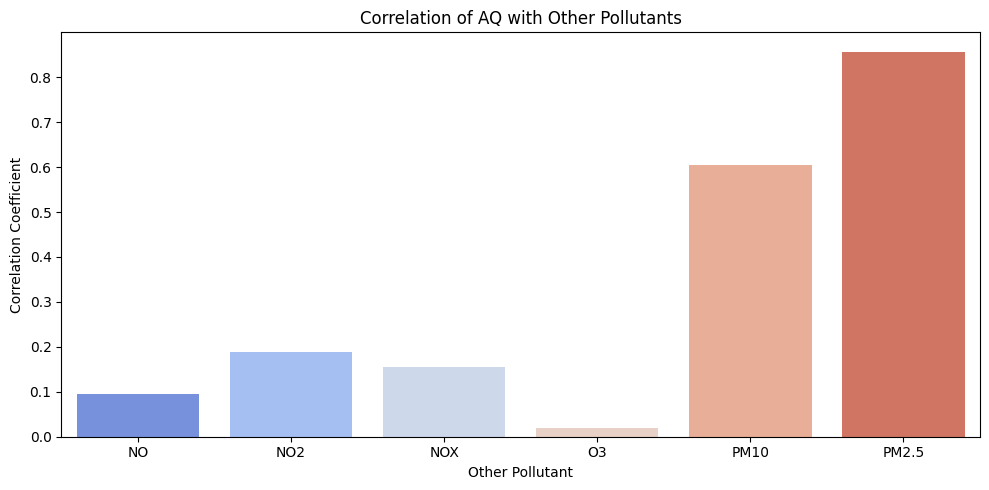

             AQ
NO     0.096082
NO2    0.187648
NOX    0.154071
O3     0.019633
PM10   0.605286
PM2.5  0.856994


In [13]:
# Visualize correlations for a specific pollutant (AQ)
pollutant = 'AQ'
AQ_corrs = aq_correlation_matrix[[pollutant]].drop(pollutant)
plt.figure(figsize=(10, 5))
sns.barplot(x=AQ_corrs.index, y=AQ_corrs[pollutant], hue=AQ_corrs.index, palette='coolwarm', legend=False)

plt.title(f'Correlation of {pollutant} with Other Pollutants')
plt.xlabel('Other Pollutant')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()
print(AQ_corrs)

PM₂.₅ exhibits by far the strongest positive correlation with AQ (r ≈ 0.89), confirming it as the primary driver of overall air quality variation in this dataset. PM₁₀ shows a moderate positive association (r ≈ 0.65), while nitrogen oxides (NO, NO₂, NOx) display only weak positive correlations (r = 0.10–0.21). Ozone has virtually no linear relationship with AQ (r ≈ 0.03). These results highlight the dominant role of fine particulate matter (PM₂.₅) in determining the AQ index, with limited direct influence from gaseous traffic-related pollutants or ozone in this monitoring context.

Number of invalid dates: 0


<Figure size 1200x800 with 0 Axes>

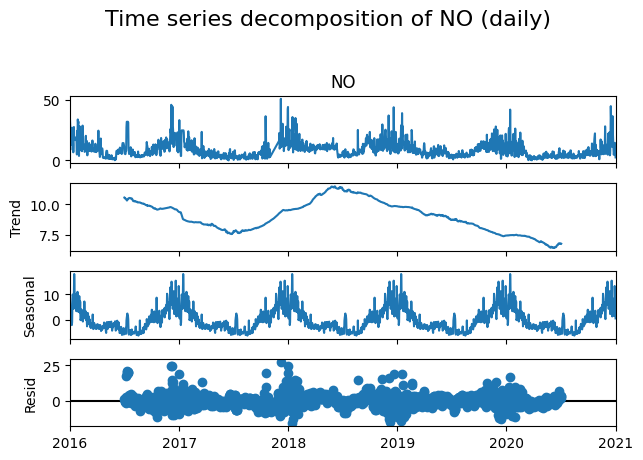

<Figure size 1200x800 with 0 Axes>

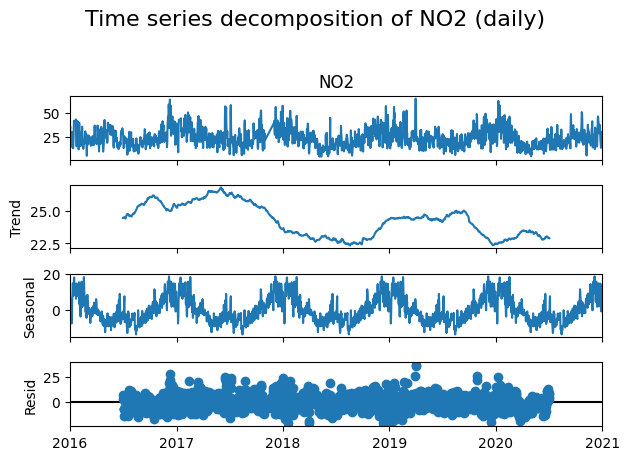

<Figure size 1200x800 with 0 Axes>

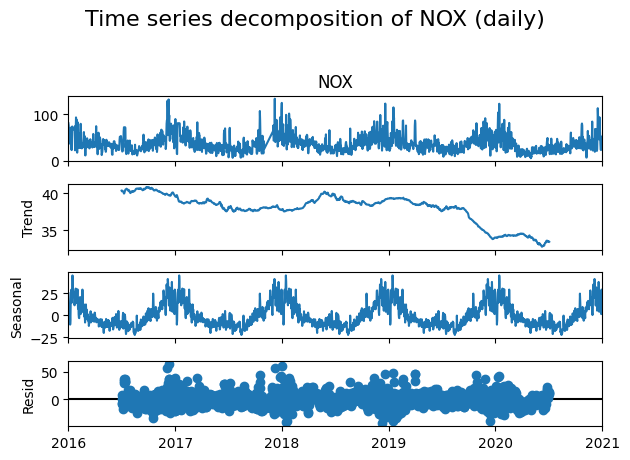

<Figure size 1200x800 with 0 Axes>

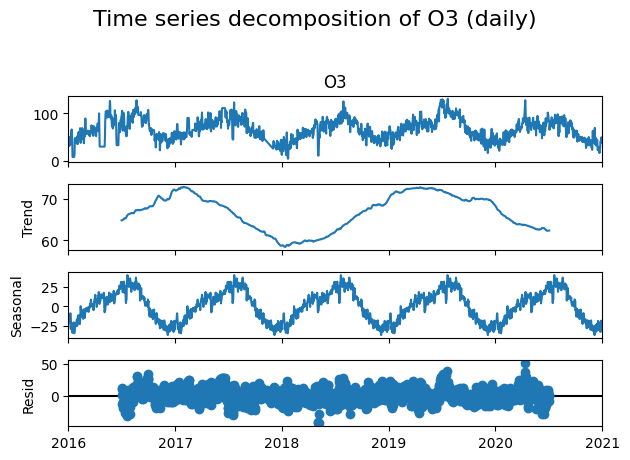

<Figure size 1200x800 with 0 Axes>

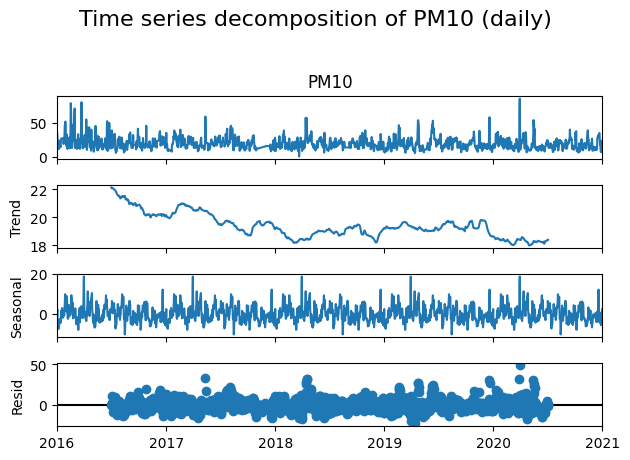

<Figure size 1200x800 with 0 Axes>

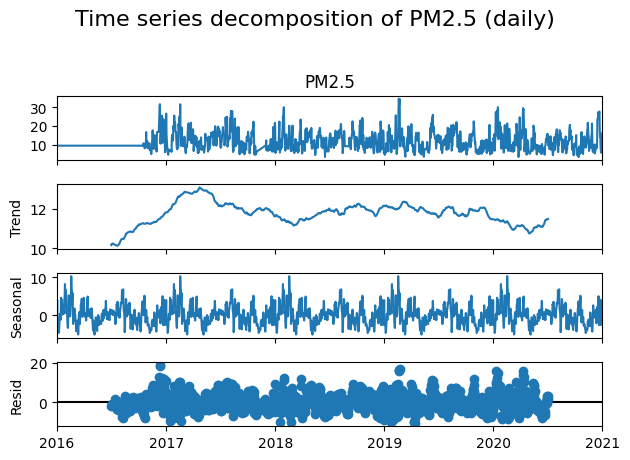

<Figure size 1200x800 with 0 Axes>

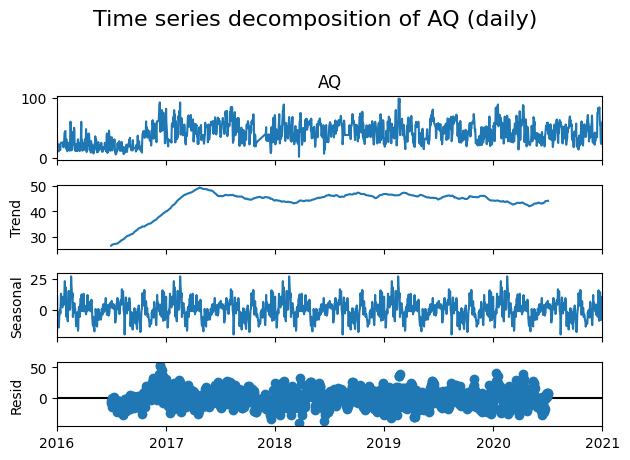

In [14]:
# TIME SERIES DECOMPOSITION
# decompose each pollutant's time series into trend, seasonality and residuals

# Parse DateTime flexibly — handles both with and without .000 microseconds
aq_df['DateTime'] = pd.to_datetime(aq_df['DateTime'], format='mixed', yearfirst=True, dayfirst=False)

# Optional: check how many rows failed to parse (should be 0 or very few)
print("Number of invalid dates:", aq_df['DateTime'].isna().sum())

# and parse the datetime format correctly (handles "YYYY-MM-DD HH:MM:SS.000")
aq_df['DateTime'] = pd.to_datetime(aq_df['DateTime'], format='%Y-%m-%d %H:%M:%S.%f')

# Handle duplicate timestamps (your CSV has exact duplicates in 2020–2021)
# by averaging values per unique datetime
aq_df = aq_df.groupby('DateTime').mean().reset_index()

# Set Datetime as index (now a proper DatetimeIndex)
aq_df.set_index('DateTime', inplace=True)

daily_df = aq_df.resample('D').mean()

# Now run decomposition on the daily series
for pollutant in pollutants:
    # Interpolate missing values (linear is reasonable for air quality gaps)
    # and drop any remaining NaNs at the start/end so seasonal_decompose runs cleanly.
    series = daily_df[pollutant].interpolate(method='linear').dropna()

    if len(series) < 365 * 2:
        print(f"Skipping {pollutant} — not enough data after cleaning.")
        continue

    # Additive decomposition with yearly seasonality (period=365 on daily data)
    decomposition = seasonal_decompose(series, model='additive', period=365)

    # Plot decomposition components
    plt.figure(figsize=(12, 8))
    decomposition.plot()
    plt.suptitle(f'Time series decomposition of {pollutant} (daily)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # makes room for suptitle
    plt.show()

*NO and NO₂* exhibit clear downward trends over the period, with NO showing a somewhat steeper decline in the later years and NO₂ maintaining a steady reduction. Both display strong winter seasonality (higher levels during colder months), consistent with increased traffic emissions, reduced dispersion, and possibly residential heating contributions in urban settings. Residuals remain relatively scattered but show episodes of higher variability, likely linked to short-term meteorological or emission events.


*NOx* (as the sum) closely mirrors the NO₂ behavior, with a noticeable downward trend (especially post-2018/2019) and pronounced winter peaks in the seasonal component. The residuals indicate moderate unexplained variability, suggesting influence from day-to-day traffic fluctuations and local conditions.

*O₃* shows a different profile: the trend is relatively flat or only mildly decreasing, with possible multi-year oscillations rather than a monotonic decline. The seasonal component is inverted compared to NOx — exhibiting clear summer maxima and winter minima — reflecting its photochemical formation dependency (higher solar radiation and temperature favor O₃ buildup). Residuals are fairly stable, indicating that much of the variation is captured by trend + strong seasonality.

*PM₁₀* presents a gradual downward trend across the years, though with noticeable year-to-year fluctuations. Seasonality is visible but less sharp than for NOx species — showing somewhat higher levels in winter (likely due to heating, resuspension, and poorer dispersion) and occasional spring/summer contributions (e.g., pollen, construction dust). Residuals are moderate and contain several spikes, pointing to episodic events (e.g., dust storms, inversions, or regional transport).

*PM₂.₅* displays a more stable or only weakly decreasing long-term trend compared to PM₁₀, with a clear increase visible in the early part of the series before leveling off or slightly declining. Seasonality remains winter-dominated (combustion + stagnation), though less extreme than gaseous primary pollutants. Residuals show considerable scatter, reflecting the influence of secondary formation processes and transboundary contributions.

*AQ* index follows a pattern very similar to PM₂.₅ — with a rising trend in the first years followed by stabilization or mild decrease, strong winter seasonality (driven by fine particle dominance), and residuals that capture unexplained day-to-day air quality excursions.

**Overall interpretation:** Emission control measures appear effective in reducing primary traffic-related pollutants (NO, NO₂, NOx), as evidenced by consistent downward trends and winter-linked seasonality. In contrast, fine particulate matter (especially PM₂.₅) and the derived AQ index show more persistent levels, suggesting a larger role of secondary aerosol formation, long-range transport, and non-traffic sources. Ozone behaves as a typical secondary photochemical pollutant — weakly trending but strongly seasonally modulated by summer conditions. These patterns collectively highlight progress on direct emissions but ongoing challenges in tackling secondary pollution and achieving further improvements in overall urban air quality.

In [15]:
#MISSING VALUE IMPUTATION
#initialize imputer with median strategy
imputer = SimpleImputer(strategy = 'median')

#impute missing values in AQ columns
aq_df[pollutants] = imputer.fit_transform(aq_df[pollutants])

#verify no missing values remain
print(aq_df[pollutants].isnull().sum())

NO       0
NO2      0
NOX      0
O3       0
PM10     0
PM2.5    0
AQ       0
dtype: int64


In [16]:
print(aq_df[pollutants].describe())
print("Skewness:\n", aq_df[pollutants].skew())

                 NO           NO2           NOX            O3          PM10  \
count  43123.000000  43123.000000  43123.000000  43123.000000  43123.000000   
mean       9.025272     24.015580     37.720194     66.188017     19.735909   
std       12.202501     17.232085     33.036900     26.967781     10.345968   
min        0.000000      0.009734      0.162730      0.000000      0.000000   
25%        2.494350     11.237166     16.304177     48.255769     13.600000   
50%        5.768315     20.354716     29.671525     65.924178     17.799990   
75%       11.433210     32.395025     49.543638     84.235745     23.600000   
max      411.701412    178.542330    796.962688    170.492181    323.565002   

              PM2.5            AQ  
count  43123.000000  43123.000000  
mean      11.520733     41.705632  
std        4.774017     17.763934  
min        3.100000      0.000000  
25%        8.600000     28.333334  
50%        9.700000     40.833333  
75%       14.100000     55.416309  


Most pollutants exhibit positive skewness, reflecting right-tailed distributions typical of urban air quality data.

NO, NO₂, and NOx show high positive skewness (>1.5–3), driven by frequent low levels punctuated by sharp traffic-related peaks.
PM₁₀ and especially PM₂.₅ display strong positive skewness (>1–2), due to episodic high-concentration events (winter stagnation, regional transport, dust).
AQ closely follows PM₂.₅ with clear positive skew, highlighting that poor air quality days are disproportionately extreme.
O₃ is the exception, with mild or near-symmetric skewness, consistent with its more gradual photochemical buildup.

Overall, the predominant positive skewness across primary pollutants and AQ underscores the intermittent, spike-dominated nature of urban pollution exposure, where rare high events contribute more to health risks than average concentrations.

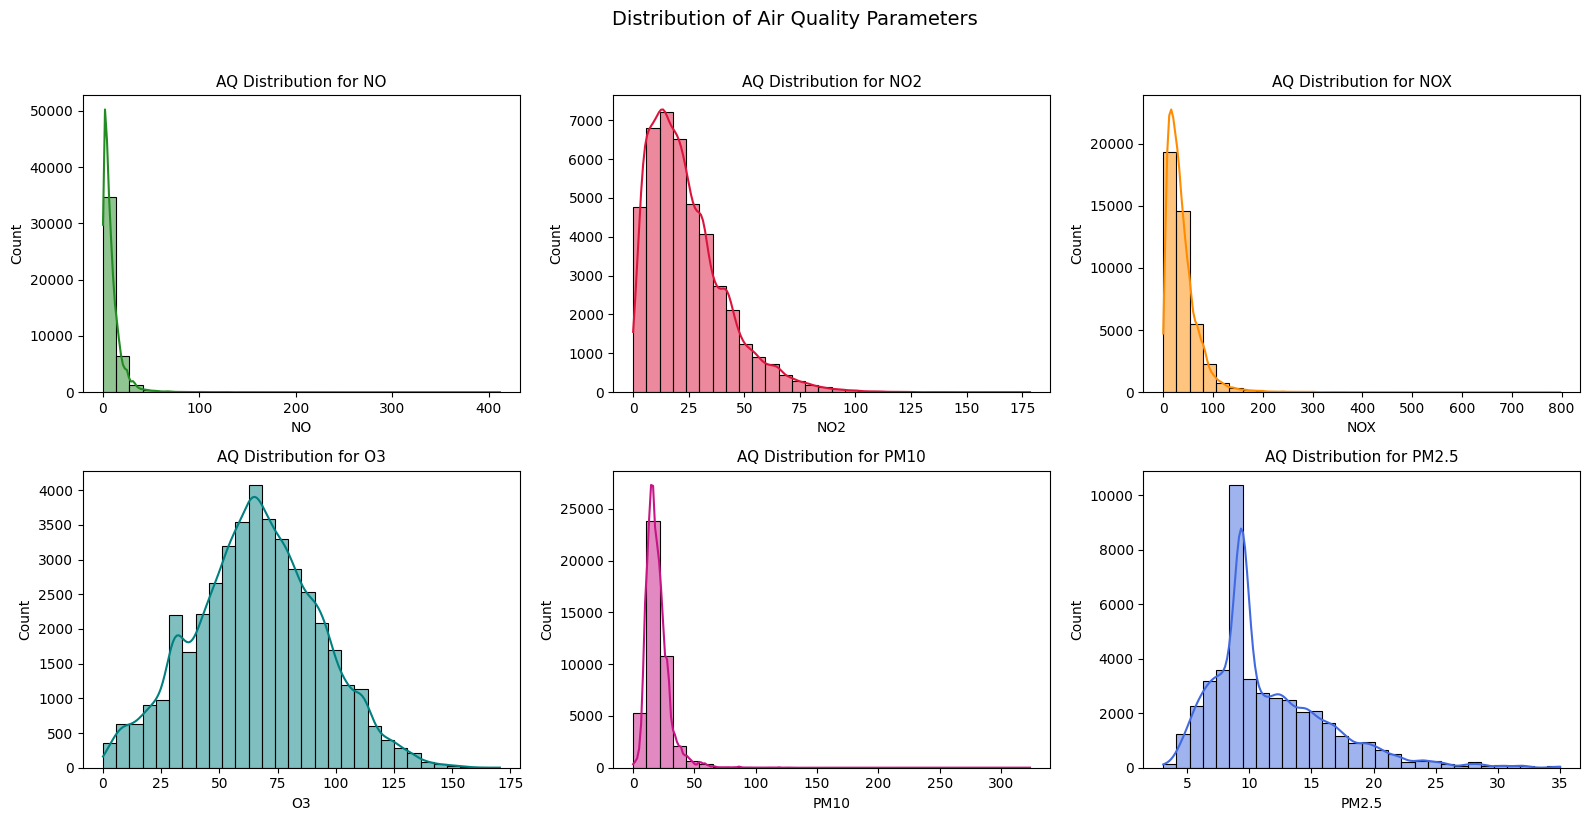

In [17]:
#DATA VISUALIZATION
colors = ['forestgreen', 'crimson', 'darkorange', 'teal', 'mediumvioletred', 'royalblue']

plt.figure(figsize=(16, 8))

for i, (pollutant, color) in enumerate(zip(pollutants, colors)):
    plt.subplot(2, 3, i+1)

    # Plot the histogram + KDE
    sns.histplot( aq_df[pollutant], kde=True, color=color, bins=30 )

    # Get min and max for this specific pollutant
    data_min = aq_df[pollutant].min()
    data_max = aq_df[pollutant].max()

    # Optional: add a small margin so the plot doesn't cut off the edges
    margin = (data_max - data_min) * 0.05
    if margin == 0:  # avoid zero range
        margin = 1.0

    # Set x-axis limits
    plt.xlim(data_min - margin, data_max + margin)

    # Improve title (full name + units if you have them)
    plt.title(f'AQ Distribution for {pollutant}', fontsize=11)

    # Optional: better x-label
    plt.xlabel(pollutant)
    plt.ylabel('Count')

# Final adjustments
plt.suptitle('Distribution of Air Quality Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The histograms reveal highly distinct distributional shapes among the pollutants, reflecting their different emission sources, formation mechanisms, and environmental behavior:

*NO, NO₂, and NOx* exhibit strongly right-skewed distributions with very sharp peaks at low concentrations (most values near 0–20 µg/m³) and long right tails extending to occasional high peaks (especially for NOx up to 400–800 µg/m³). This pattern is typical of primary traffic-related pollutants in urban environments: frequent background/low levels interrupted by short, intense emission spikes (e.g., rush hour, congestion).

*O₃* shows a much more symmetric, bell-shaped (near-normal) distribution centered around 50–75 µg/m³, with a moderate spread and fewer extreme outliers. This reflects ozone's secondary photochemical nature — produced gradually over larger areas and influenced by temperature, sunlight, and precursor availability rather than direct point sources.

*PM₁₀* and especially *PM₂.₅* display right-skewed distributions with prominent modes at low-to-moderate levels (~10–25 µg/m³ for PM₂.₅, ~15–40 µg/m³ for PM₁₀) but clear right tails indicating episodic high-concentration days (up to 100–300 µg/m³ for PM₁₀). The skewness is less extreme than for NOx, consistent with a mix of local sources, secondary formation, and regional/long-range transport contributions.

**Overall**, the contrast between the highly skewed, spike-driven distributions of primary pollutants (NO/NO₂/NOx) and the more symmetric profile of ozone highlights the fundamental difference between direct emissions and secondary photochemical pollutants. Particulate matter distributions fall in between — moderately skewed — underscoring their hybrid origin (primary + secondary processes) and the importance of rare high episodes in driving overall exposure and air quality exceedances.

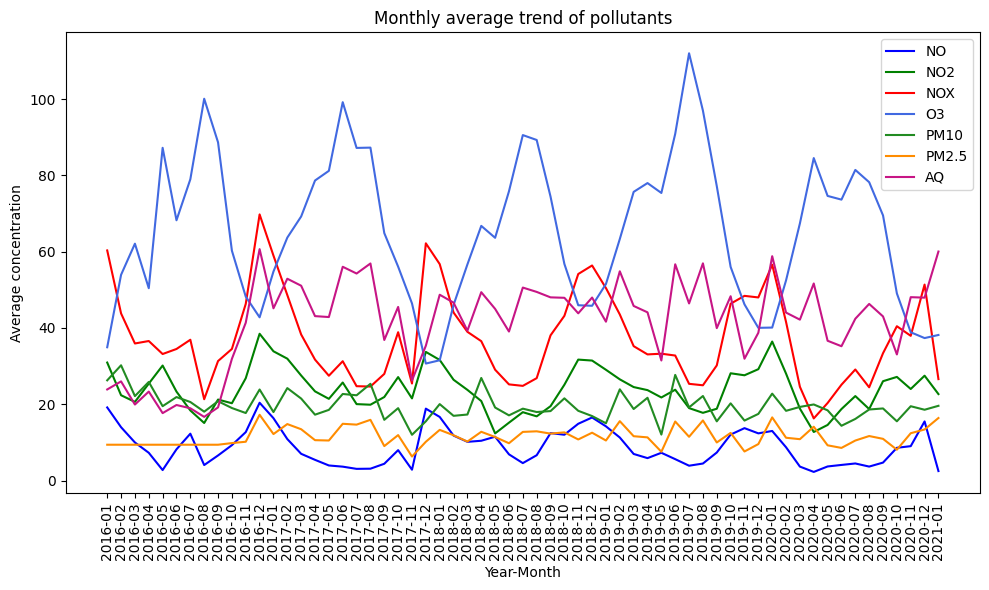

In [18]:
#monthly trend analysis
#create Year-Month period column for aggregation
aq_df['Year-Month'] = aq_df.index.to_period('M')

#calculate monthly averages for each pollutant
multi_pollutant_monthly_avg = aq_df.groupby('Year-Month')[pollutants].mean()

colors = ['blue', 'green', 'red', 'royalblue', 'forestgreen', 'darkorange', 'mediumvioletred']

#plot monthly trends
plt.figure(figsize = (10, 6))
for pollutant, color in zip(pollutants, colors):
    plt.plot(multi_pollutant_monthly_avg.index.astype(str), multi_pollutant_monthly_avg[pollutant], label = pollutant, color = color)
plt.title('Monthly average trend of pollutants')
plt.xlabel('Year-Month')
plt.ylabel('Average concentration')
plt.xticks(rotation = 90)
plt.legend()
plt.tight_layout()
plt.show()

count    43123.000000
mean         9.025272
std         12.202501
min          0.000000
25%          2.494350
50%          5.768315
75%         11.433210
max        411.701412
Name: NO, dtype: float64
DateTime
1     15.885364
2     11.339412
3      7.562010
4      6.263093
5      5.841099
6      5.688287
7      5.665250
8      4.394103
9      7.101260
10     9.986914
11    12.589762
12    16.737209
Name: NO, dtype: float64


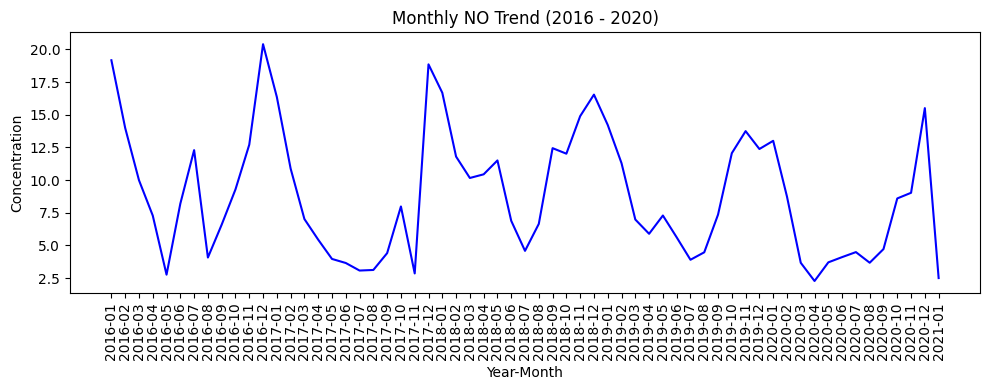

In [19]:
print(aq_df['NO'].describe()) #basic statistics
print(aq_df['NO'].groupby(aq_df.index.month).mean()) #monthly averages

plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NO'],
         color = colors[0], label = 'NO')
plt.title('Monthly NO Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        24.015580
std         17.232085
min          0.009734
25%         11.237166
50%         20.354716
75%         32.395025
max        178.542330
Name: NO2, dtype: float64
DateTime
1     32.385601
2     27.042359
3     23.066115
4     21.223376
5     20.063685
6     21.357052
7     19.502534
8     17.666087
9     21.505568
10    25.565832
11    27.538299
12    32.075435
Name: NO2, dtype: float64


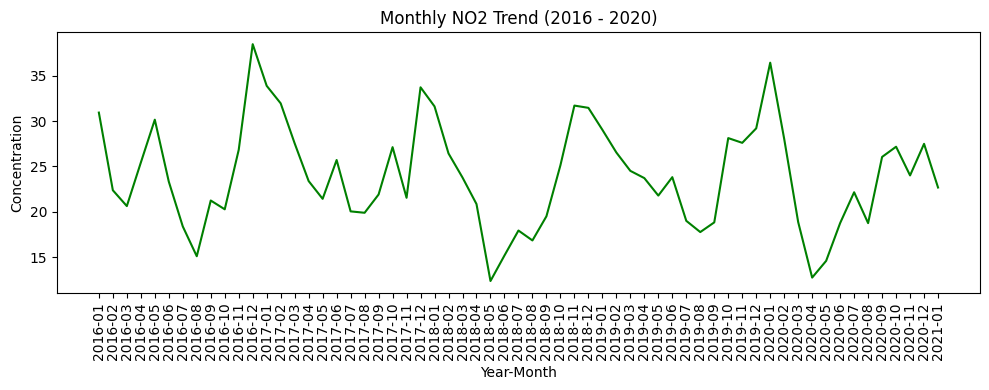

In [20]:

print(aq_df['NO2'].describe()) #basic statistics
print(aq_df['NO2'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NO2'],
         color = colors[1], label = 'NO2')
plt.title('Monthly NO2 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()


count    43123.000000
mean        37.720194
std         33.036900
min          0.162730
25%         16.304177
50%         29.671525
75%         49.543638
max        796.962688
Name: NOX, dtype: float64
DateTime
1     56.616811
2     44.306861
3     34.610479
4     30.841689
5     28.665180
6     29.783135
7     28.193915
8     24.452729
9     32.189201
10    40.684004
11    46.702316
12    57.548631
Name: NOX, dtype: float64


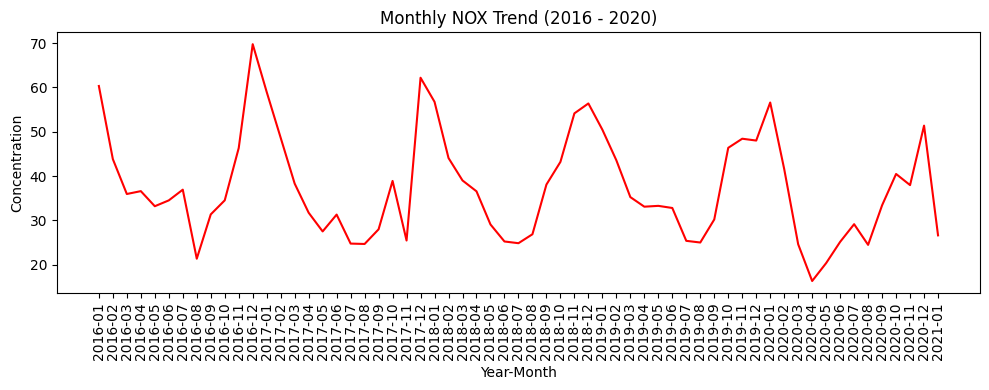

In [21]:
print(aq_df['NOX'].describe()) #basic statistics
print(aq_df['NOX'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['NOX'],
         color = colors[2], label = 'NOX')
plt.title('Monthly NOX Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        66.188017
std         26.967781
min          0.000000
25%         48.255769
50%         65.924178
75%         84.235745
max        170.492181
Name: O3, dtype: float64
DateTime
1     42.585811
2     55.860629
3     66.220373
4     71.678509
5     76.420216
6     81.564930
7     90.045034
8     90.374688
9     74.939167
10    55.640762
11    44.813421
12    39.342222
Name: O3, dtype: float64


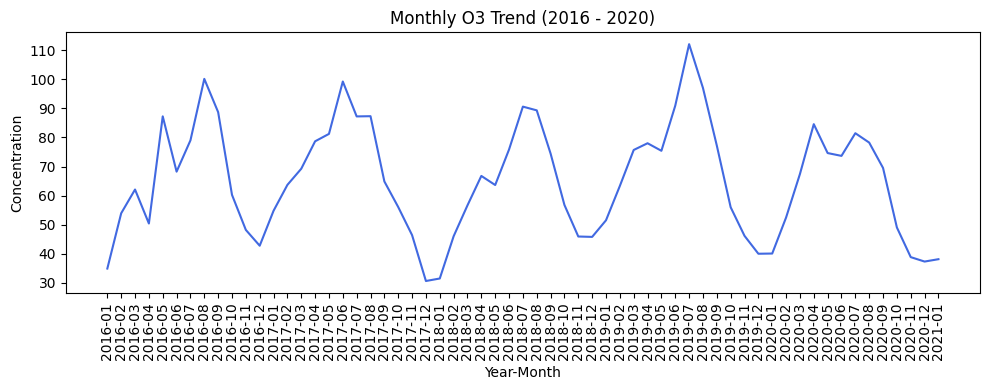

In [22]:
print(aq_df['O3'].describe()) #basic statistics
print(aq_df['O3'].groupby(aq_df.index.month).mean()) #monthly averages

plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['O3'],
         color = colors[3], label = 'O3')
plt.title('Monthly O3 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

count    43123.000000
mean        19.735909
std         10.345968
min          0.000000
25%         13.600000
50%         17.799990
75%         23.600000
max        323.565002
Name: PM10, dtype: float64
DateTime
1     20.420473
2     22.752128
3     19.808096
4     22.338641
5     17.533981
6     20.752630
7     19.430864
8     20.440726
9     17.877419
10    19.070211
11    17.803366
12    18.476875
Name: PM10, dtype: float64


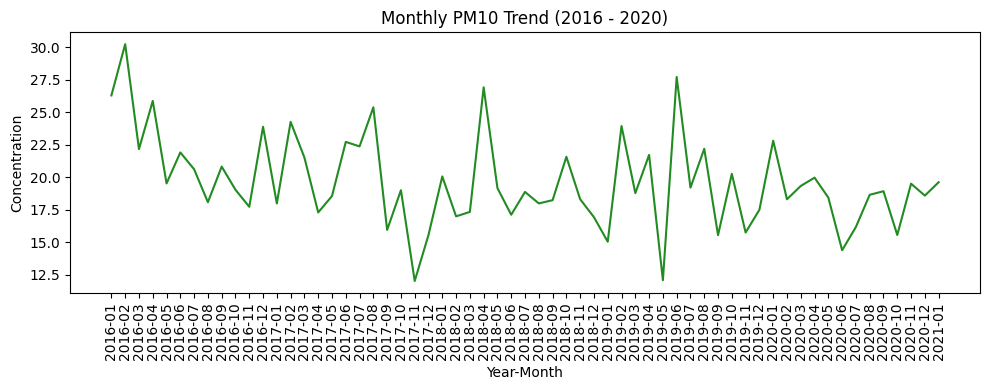

In [23]:
print(aq_df['PM10'].describe()) #basic statistics
print(aq_df['PM10'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['PM10'],
         color = colors[4], label = 'PM10')
plt.title('Monthly PM10 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()


count    43123.000000
mean        11.520733
std          4.774017
min          3.100000
25%          8.600000
50%          9.700000
75%         14.100000
max         35.000000
Name: PM2.5, dtype: float64
DateTime
1     12.391870
2     12.548620
3     11.113763
4     11.645333
5      9.624435
6     11.625389
7     11.762097
8     13.136021
9     10.336555
10    10.996989
11    10.248768
12    12.588948
Name: PM2.5, dtype: float64


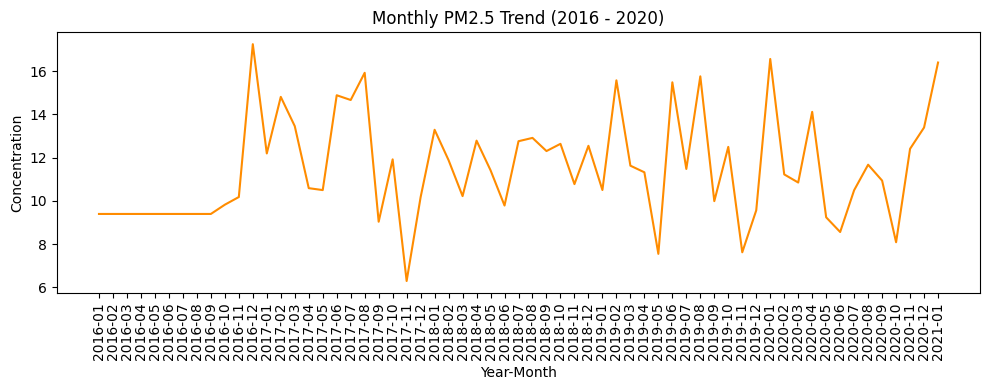

In [24]:
print(aq_df['PM2.5'].describe()) #basic statistics
print(aq_df['PM2.5'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['PM2.5'],
         color = colors[5], label = 'PM2.5')
plt.title('Monthly PM2.5 Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()



count    43123.000000
mean        41.705632
std         17.763934
min          0.000000
25%         28.333334
50%         40.833333
75%         55.416309
max        184.936213
Name: AQ, dtype: float64
DateTime
1     43.649735
2     44.752031
3     39.654957
4     42.320692
5     34.739854
6     41.370968
7     42.538734
8     45.266020
9     37.414294
10    41.346636
11    41.308038
12    46.145878
Name: AQ, dtype: float64


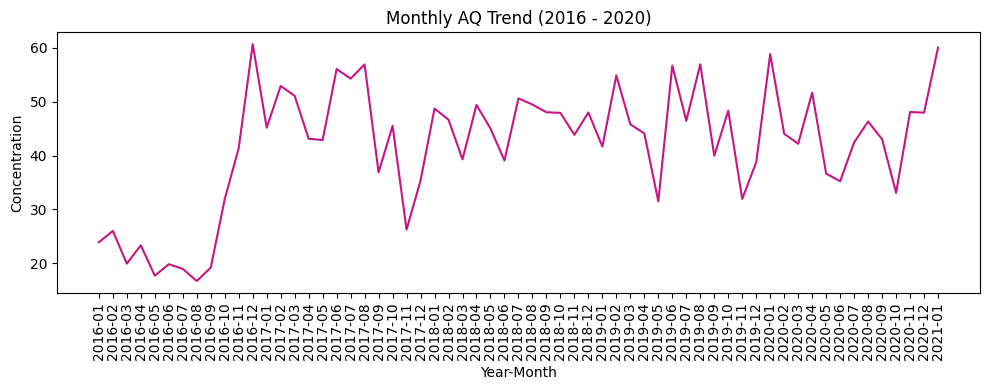

In [25]:
print(aq_df['AQ'].describe()) #basic statistics
print(aq_df['AQ'].groupby(aq_df.index.month).mean()) #monthly averages


plt.figure(figsize = (10, 4))
plt.plot(multi_pollutant_monthly_avg.index.astype(str),
         multi_pollutant_monthly_avg['AQ'],
         color = colors[6], label = 'AQ')
plt.title('Monthly AQ Trend (2016 - 2020)')
plt.xlabel('Year-Month')
plt.ylabel('Concentration')
plt.xticks(rotation = 90)
plt.grid(False)
plt.tight_layout()
plt.show()

Primary traffic-related gases *(NO, NO₂, NOx)* show the most consistent downward trends, especially noticeable from ~2018/2019 onward. Peaks are regularly higher in winter months (heating + poor dispersion + traffic), but the overall multi-year decline points to effective reductions in road traffic emissions (e.g., cleaner vehicles, traffic management, or policy measures).

*O₃* exhibits a relatively flat to mildly decreasing trend with strong opposing seasonality: clear summer maxima and winter minima. This classic photochemical behavior shows little evidence of a strong secular decline, consistent with ozone's dependence on precursors, temperature, and solar radiation rather than direct local emissions alone.

Particulate matter *(PM₁₀ and PM₂.₅)* displays gradual declines or stabilization after earlier fluctuations. PM₁₀ shows more year-to-year variability (possibly influenced by dust episodes or resuspension), while PM₂.₅ — the more health-relevant fraction — appears more persistent with only modest improvement. Both maintain pronounced winter elevations, highlighting the role of combustion, stagnation, and secondary formation.

*AQ* index closely tracks PM₂.₅ in both level and trend: an initial rise or high variability in the earlier years, followed by relative stabilization or slow improvement. The AQ remains clearly winter-dominated, reinforcing that fine particle levels are the main driver of overall air quality excursions in this dataset.

Emission controls appear successful in steadily reducing primary gaseous pollutants (NOx family), but progress on particulate matter and derived air quality is slower and less pronounced — likely due to the growing relative importance of secondary aerosol processes, regional transport, residential combustion, and meteorological factors. Ozone dynamics remain largely decoupled from local primary emission trends, reflecting its secondary and regional-scale nature. These patterns underscore the need for continued, multi-pollutant strategies beyond traffic-focused measures to achieve meaningful further improvements in urban air quality.

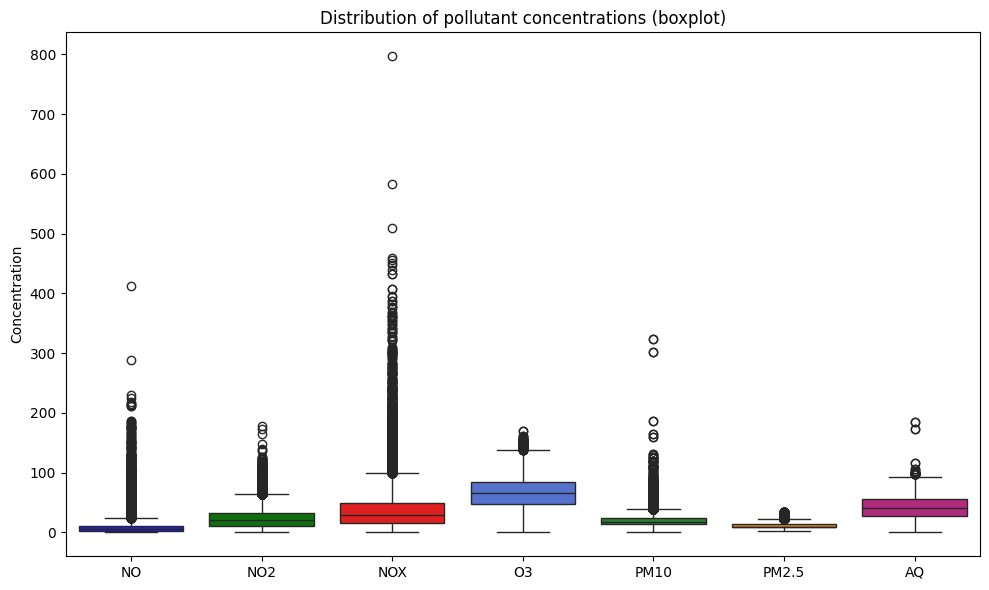

In [26]:
#boxplot visualization
plt.figure(figsize = (10, 6))
sns.boxplot(data = aq_df[pollutants], palette = colors)
plt.title('Distribution of pollutant concentrations (boxplot)')
plt.ylabel('Concentration')
plt.tight_layout()
plt.show()

The boxplots illustrate the central tendency, spread, and presence of outliers for each pollutant and the Air Quality index (AQ), highlighting their markedly different concentration ranges and variability:

*NO, NO₂,* and especially *NOx* show very low median concentrations (close to 0–20 µg/m³) but extremely long upper whiskers and numerous high outliers (NOx reaching up to ~800 µg/m³). This reflects the typical urban pattern for primary traffic-related gases: most days have low/background levels, but occasional sharp peaks (e.g., traffic congestion, cold starts, poor dispersion) produce extreme values.

*O₃* has a higher median (~50–70 µg/m³), a relatively symmetric interquartile range, and fewer/milder outliers. This is consistent with its secondary photochemical origin — more stable daily levels influenced by sunlight and temperature rather than direct local spikes.

*PM₁₀ and PM₂.₅* display moderate medians (~20–40 µg/m³ for PM₁₀, ~10–20 µg/m³ for PM₂.₅) with moderate spread and a clear right-skew (longer upper whiskers and several outliers, especially for PM₁₀ up to ~300 µg/m³). The outliers represent episodic high events (winter inversions, dust episodes, regional transport), while the bulk of data remains in a narrower, lower range.
AQ index closely resembles PM₂.₅ in both median level and distribution shape, with a moderate interquartile range and noticeable upper outliers — confirming that fine particulate matter drives the most extreme (poor) air quality days.

**Overall:** The boxplots emphasize the intermittent, right-skewed nature of urban air pollution — particularly for primary pollutants (NO/NO₂/NOx) and particulates — where rare but intense episodes create high outliers that disproportionately affect health exposure and AQ exceedances. In contrast, ozone shows more stable, less outlier-prone behavior, highlighting its different (secondary) formation pathway.

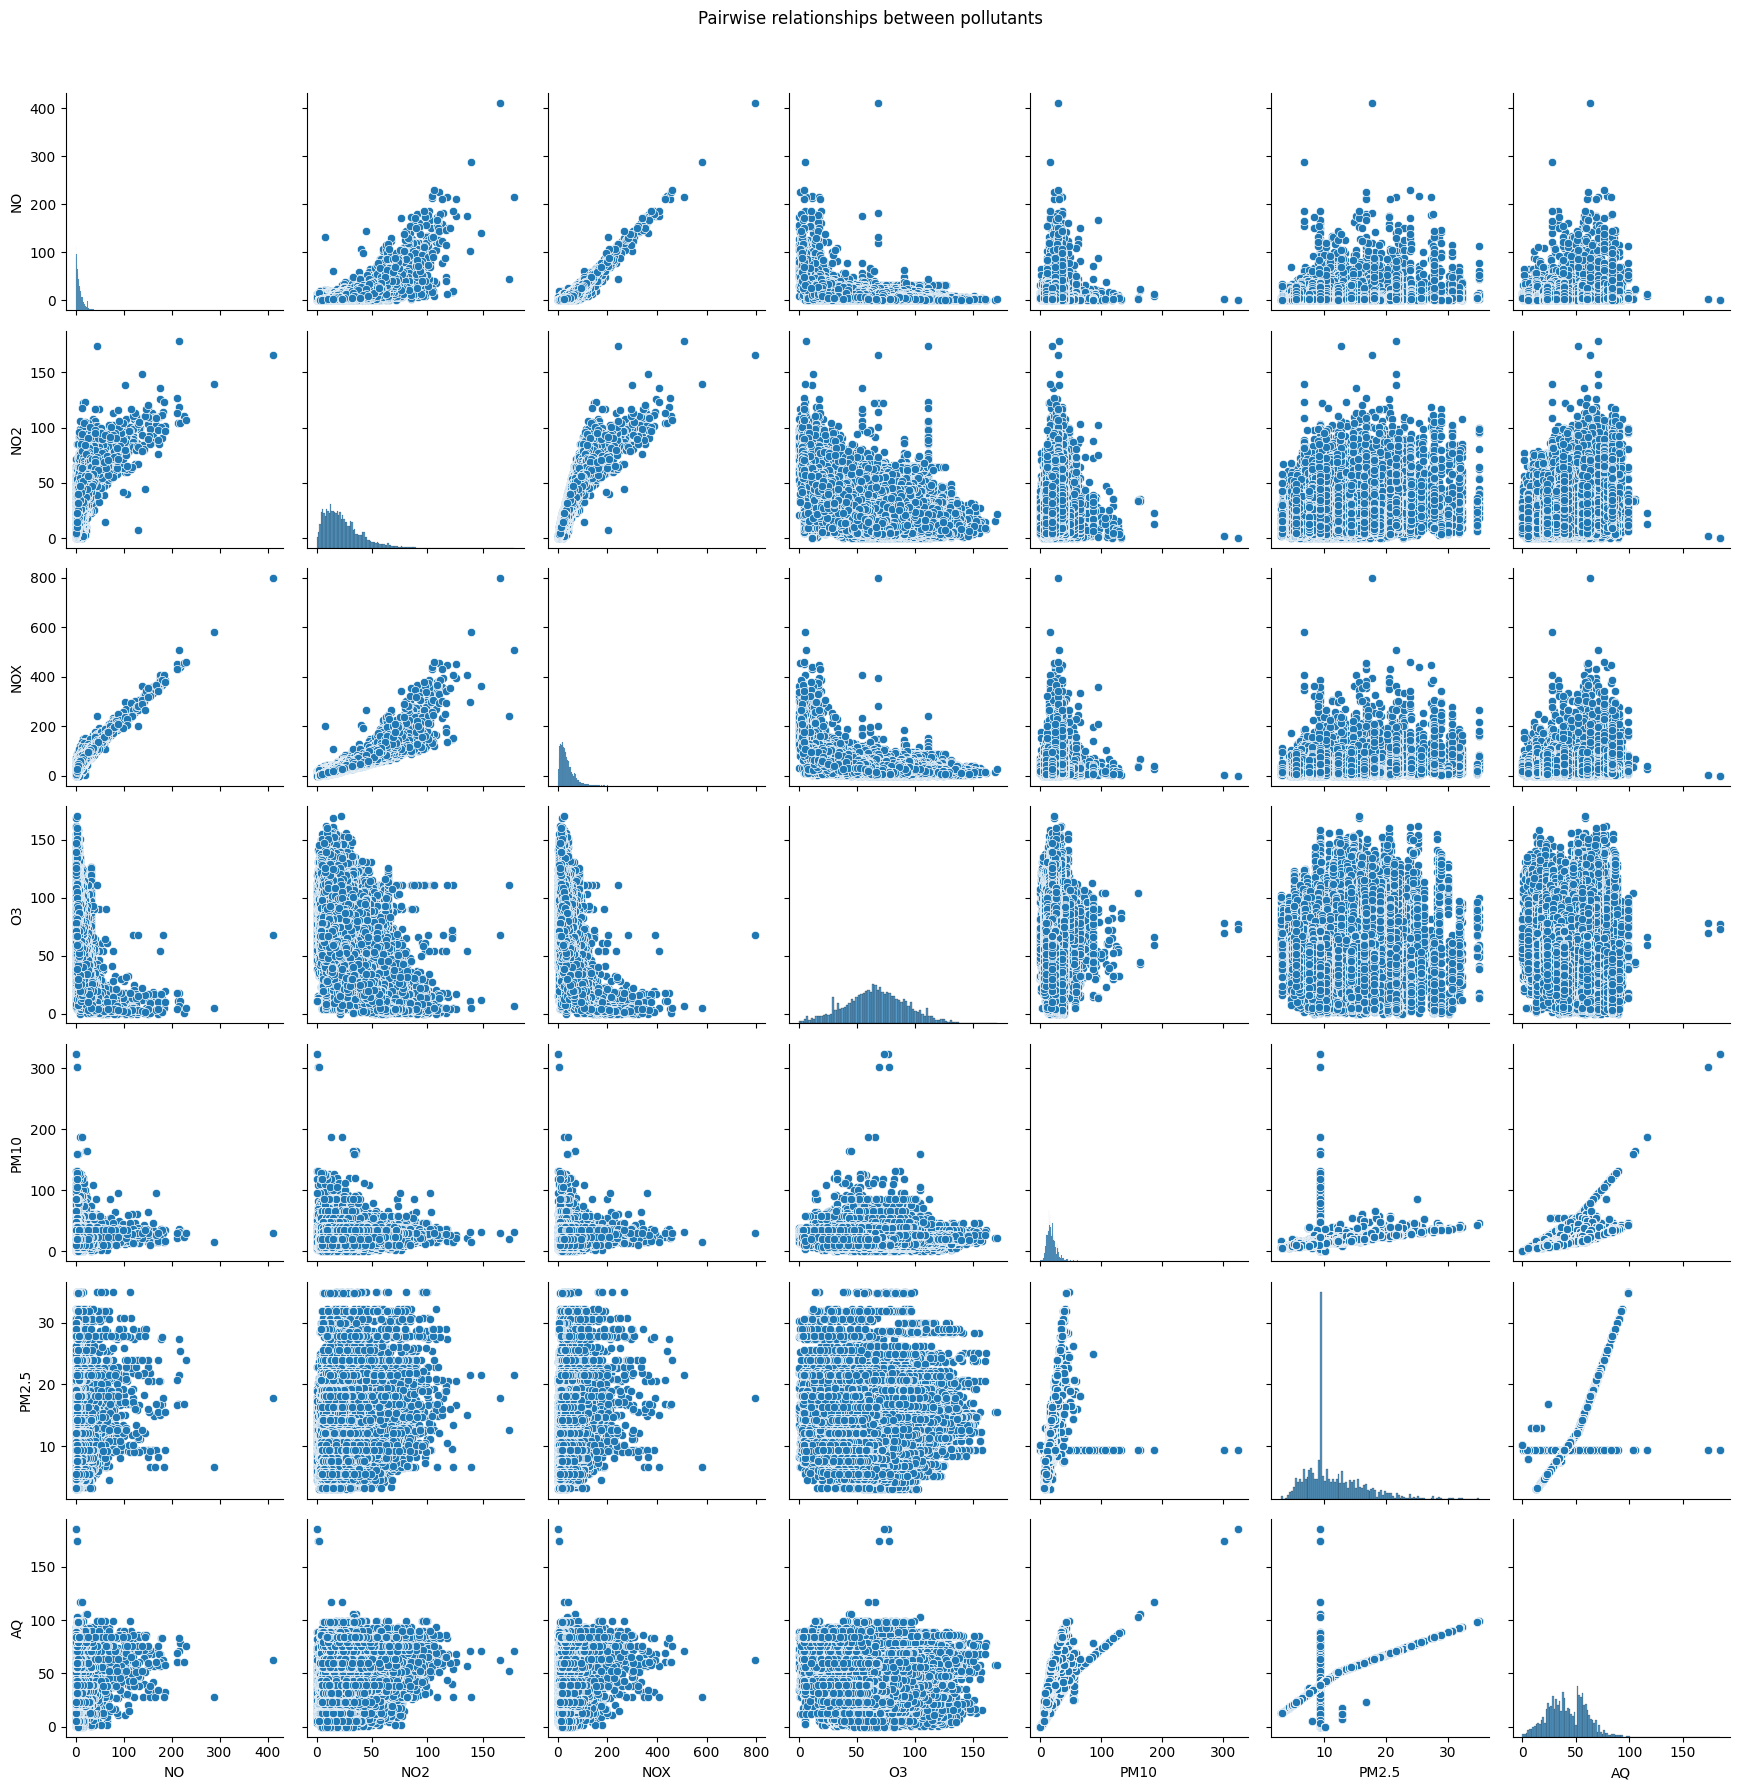

In [27]:
#pairwise relationships (pairplot)
sns.pairplot(aq_df[pollutants])
plt.suptitle('Pairwise relationships between pollutants', y = 1.02)
plt.tight_layout()
plt.show()

The pairplot visualizes bivariate relationships and marginal distributions for all pollutants (NO, NO₂, NOx, O₃, PM₁₀, PM₂.₅) and the Air Quality index (AQ), revealing both linear and nonlinear patterns as well as distributional characteristics:

Strong linear positive relationships are clearly visible within the nitrogen oxides group:

*NO ↔ NO₂ ↔ NOx* show tight, near-linear clouds with very high positive slopes — consistent with their direct chemical linkage (NOx ≈ NO + NO₂) and common traffic origin. The scatter points concentrate along a strong diagonal trend.

*PM₂.₅ ↔ AQ* exhibits the strongest and most linear positive association among all pairs — points tightly follow an upward trend with very little scatter, confirming PM₂.₅ as the dominant driver of the overall Air Quality index.

*PM₁₀ ↔ PM₂.₅* shows a clear positive (though more scattered) relationship — typical of particulate fractions where fine particles form a subset of coarse ones, but with additional coarse-mode contributions (e.g., dust, resuspension).
NOx group vs O₃ displays a characteristic negative (antagonistic) pattern — higher NOx concentrations correspond to lower O₃ levels, especially evident in the left part of the plots (high NOx → low O₃). The relationship appears nonlinear (more curved or threshold-like), with O₃ concentrations plateauing or dropping sharply at higher NOx levels — classic urban NOx-titration effect.

*O₃ vs PM* fractions / AQ shows almost no clear linear or monotonic relationship — scatter is diffuse with no obvious trend, reflecting independent or complexly coupled processes (photochemical vs. primary/secondary aerosol dynamics).

*NOx group vs PM* fractions generally shows weak positive scatter with high dispersion — only a loose tendency toward higher PM at higher NOx, suggesting traffic is not the dominant source of particulate matter in this dataset.

**Marginal distributions** (diagonal histograms) confirm earlier findings:

*NO, NO₂, NOx* are strongly right-skewed (most values near zero, long right tails from peak events).
*O₃* is roughly symmetric/bell-shaped.
*PM₁₀, PM₂.₅ and AQ* are moderately right-skewed with prominent low-value modes but clear tails of high episodes.

**Overall interpretation:**
The pairplot highlights that the strongest structured (mostly linear) dependencies occur within the NOx family and between PM₂.₅ and AQ. The NOx–O₃ antagonism is visible but appears nonlinear, while most other cross-relationships (especially involving particulates and ozone) are weak and diffuse — pointing to different dominant sources and formation pathways. These visual patterns align well with the earlier correlation, distance correlation, and distributional analyses, emphasizing the central role of fine particles in driving air quality and the limited direct influence of primary traffic emissions on PM levels in this urban context.

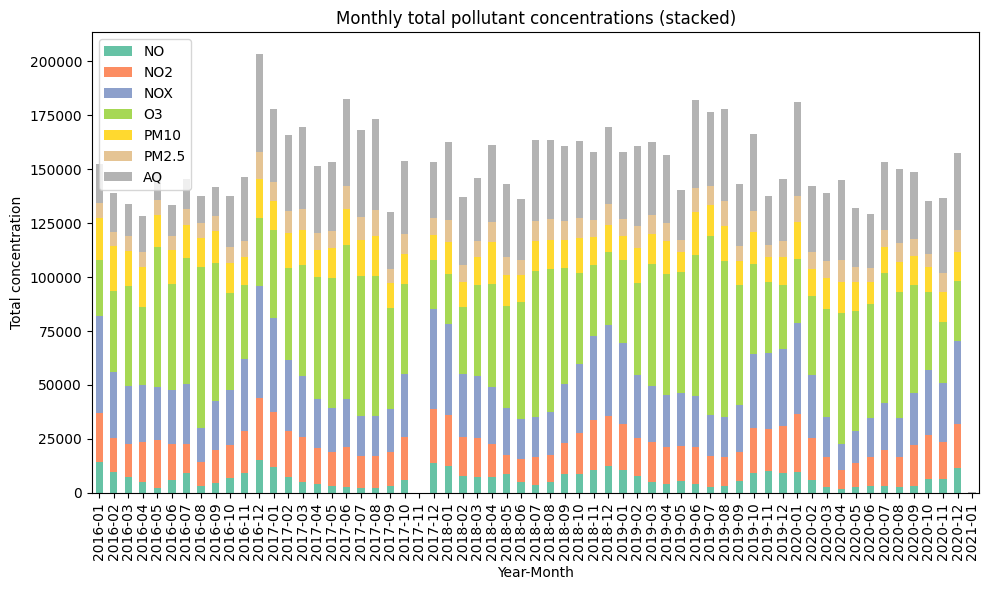

In [28]:
#stacked monthly totals
pollution_monthly_sum = aq_df.groupby('Year-Month')[pollutants].sum()
pollution_monthly_sum.plot(kind = 'bar', stacked = True, figsize = (10, 6), colormap = 'Set2')
plt.title('Monthly total pollutant concentrations (stacked)')
plt.xlabel('Year-Month')
plt.ylabel('Total concentration')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

The stacked area plot displays the monthly cumulative contribution of each pollutant (NO, NO₂, NOx, O₃, PM₁₀, PM₂.₅) to the total pollutant load, with the top edge representing the summed concentration (closely aligned with the AQ index trend in gray).

**Overall pattern:** Total monthly pollutant burden shows a general declining tendency from 2016 peaks (180,000–200,000 µg/m³ summed) toward lower levels in 2020–2021 (120,000–150,000 µg/m³), interrupted by seasonal fluctuations and some year-to-year variability. This suggests progressive emission reductions over the period.

**Dominant contributors:**
*NOx family (NO + NO₂ + NOx)* occupies the largest share in most months (especially 2016–2018), forming the thick blue/red/green base of the stack. Their contribution visibly shrinks over time, particularly after 2018/2019 — the clearest sign of successful traffic-related emission controls.

*O₃* (orange) shows the opposite seasonal behavior: strong summer peaks that often become the tallest segment in warmer months, while nearly disappearing in winter. Its relative contribution increases in later years as NOx decreases (less titration → more ozone availability).

*PM₁₀ and PM₂.₅* (yellow/brown) form a more stable mid-layer. PM₁₀ contributes more volume overall, but PM₂.₅ maintains a consistent presence year-round. Both show winter elevations and a modest long-term reduction, though less pronounced than NOx.

*AQ* index alignment: The gray AQ line tracks the upper boundary of the stack reasonably well, but with noticeable divergence in summer (when O₃ rises but AQ often does not spike proportionally) → confirming that AQ is primarily driven by PM levels (especially PM₂.₅) rather than the total pollutant sum or gaseous species.

**Key takeaway:** The plot illustrates successful reductions in primary traffic pollutants (NOx group) over the years, while secondary pollutants (O₃ in summer) and particulates (PM₁₀/PM₂.₅ in winter) remain persistent contributors to the total load. The AQ index is disproportionately influenced by fine particle episodes rather than the cumulative gaseous burden, highlighting the need for targeted strategies beyond traffic emission controls to further improve overall air quality.

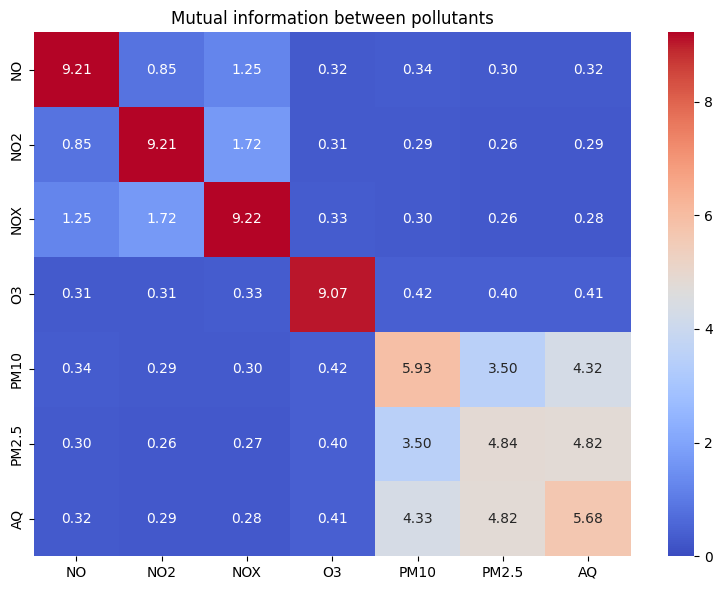

In [29]:
#MUTUAL INFORMATION ANALYSIS
#prepare feature matrix
X = aq_df[pollutants]

#calculate mutual information between all pollutants
mutual_info_all = {}
for target in X.columns:
    mutual_info = mutual_info_regression(X, X[target])
    mutual_info_all[target] = mutual_info

#convert to DataFrame for visualization
mutual_info_df = pd.DataFrame(mutual_info_all, index = X.columns)

#plot mutual information heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(mutual_info_df, annot = True, cmap = 'coolwarm', fmt = '.2f', vmin = 0)
plt.title('Mutual information between pollutants')
plt.tight_layout()
plt.show()

Mutual information reveals strong shared information within the *NOx group* (NO–NO₂–NOx: MI ≈ 9.2 bits), confirming their near-complete redundancy due to chemical linkage.

*PM₂.₅* shows the highest MI with AQ (5.68 bits), followed by *PM₁₀–AQ* (4.32 bits) and *PM₂.₅–PM₁₀* (3.49 bits), underlining fine particles as the main driver of air quality variation — even when capturing nonlinear dependencies.
O₃ has low MI with all other variables (≈ 0.3–0.4 bits), indicating largely independent behavior.

*NOx–PM and NOx–AQ* links remain weak (≈ 0.26–0.34 bits), reinforcing that particulates and AQ are influenced more by secondary processes or non-traffic sources than direct traffic emissions.

**Overall**, MI highlights PM₂.₅ dominance in AQ and NOx internal redundancy, while ozone and particulates carry mostly separate information from primary gases.

**PART 2: Model Development and Evaluation**

This section focuses on building and evaluating predictive models for AQ levels based on other pollutant measurements (PM10, NO2, NH3, Toluene, Xylene). We will:

1. Prepare the data for modeling (train-test split)

2. Compare three regression approaches:

  - Ridge Regression (linear model with regularization)

  - Decision Tree (non-linear, interpretable)

  - Random Forest (ensemble method)

3. Perform model diagnostics and validation

4. Evaluate final performance metrics

5. Try three Dummy's models to compare my previous regression values.


Key techniques used:

  - Residual analysis

  - Validation curves

  - Feature importance

  - Learning curves

  - Out-of-Bag (OOB) scoring

In [30]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score

In [31]:
#DATA PREPARATION
#prepare feature matrix (other pollutants) and target (NO2)
X = aq_df[['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']].values
y = aq_df['AQ'].values

#split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
models = {
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(oob_score = True)
}

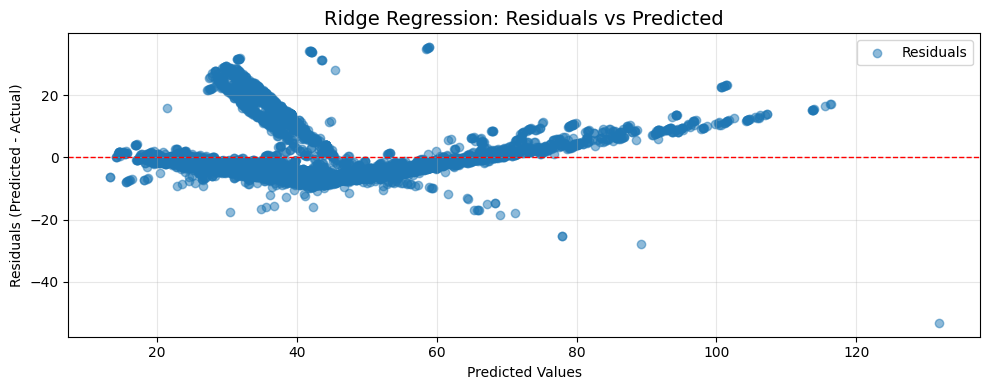

In [33]:
#RIDGE REGRESSION
#fit ridge model
models['Ridge Regression'].fit(X_train, y_train)
y_pred_lr = models['Ridge Regression'].predict(X_test)
residuals = y_pred_lr - np.array(y_test)

#plot residuals (predicted vs actual differences)
plt.figure(figsize = (10, 4))
plt.scatter(y_pred_lr, residuals, alpha=0.5, label = 'Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 1)
plt.title('Ridge Regression: Residuals vs Predicted', fontsize = 14)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

Residuals vs. predicted values plot shows acceptable central tendency (residuals ≈0 across most of the range) and moderate fit, with ~90% of points lying within ±20.

However, clear diagnostic issues are present:

*Heteroscedasticity:* residual variance is larger at low predicted AQ (20–40), decreasing toward higher values → fan-shaped pattern opening leftward.
Nonlinearity / model misspecification: systematic curved pattern in mid-range (30–60), with negative residuals (under-prediction) at moderate predictions and shift to positive residuals (over-prediction) at higher predictions.
*Outliers:* several large negative residuals at high predicted values (>100), indicating over-prediction during extreme episodes; fewer positive outliers at low predictions.

These patterns suggest unmodeled nonlinearities (likely in PM₂.₅–AQ or NOx–O₃ relationships), possible omitted variable bias (meteorology, seasonality, interactions), and limited ability of linear Ridge to capture threshold or saturation effects during pollution peaks.

**Conclusion:** While Ridge effectively captures the dominant linear signal (mainly PM₂.₅), residual structure indicates benefit from nonlinear extensions (e.g., polynomial features, splines, tree-based models, or GAM) and inclusion of meteorological / temporal covariates to reduce bias, heteroscedasticity, and extreme-event error.

In [34]:
#DECISION TREE
#validation curve to determine optimal tree depth
depths = range(1, 11)
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state = 42),
    X_train, y_train, param_name = "max_depth",
    param_range = depths,
    cv = 5,       #5-fold cross-validation
    scoring = "r2" #R-squared metric
)

In [35]:
#calculate the average of validation scores
mean_test_scores = np.mean(test_scores, axis = 1)

#find the max_depth with the highest R2 score
optimal_depth = depths[np.argmax(mean_test_scores)]
print(f"Optimal max_depth based on validation curve: {optimal_depth}")

for depth, score in zip(depths, mean_test_scores):
    print(f"Depth {depth}: R2 = {score:.3f}")

models['Decision Tree'] = DecisionTreeRegressor(max_depth = optimal_depth, random_state = 42)
models['Decision Tree'].fit(X_train, y_train)

Optimal max_depth based on validation curve: 10
Depth 1: R2 = 0.653
Depth 2: R2 = 0.779
Depth 3: R2 = 0.855
Depth 4: R2 = 0.892
Depth 5: R2 = 0.928
Depth 6: R2 = 0.965
Depth 7: R2 = 0.977
Depth 8: R2 = 0.983
Depth 9: R2 = 0.986
Depth 10: R2 = 0.989


DecisionTreeRegressor(max_depth=10, random_state=42)

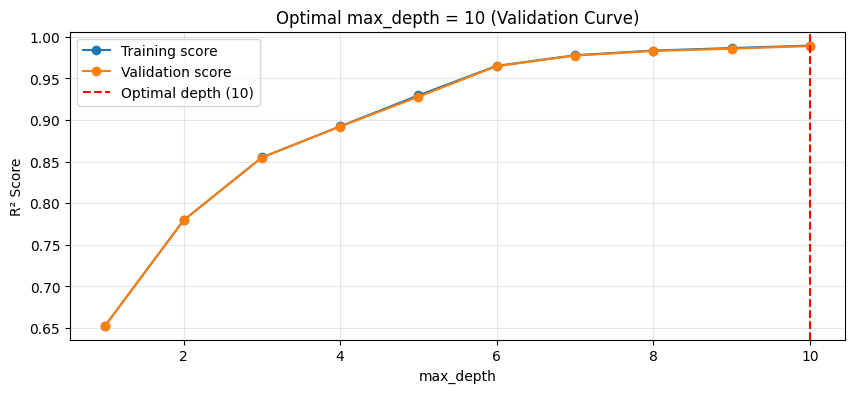

In [36]:
#plot
plt.figure(figsize = (10, 4))
plt.plot(depths, np.mean(train_scores, axis = 1), 'o-', label = 'Training score')
plt.plot(depths, mean_test_scores, 'o-', label = 'Validation score')
plt.axvline(x = optimal_depth, color = 'r', linestyle = '--', label = f'Optimal depth ({optimal_depth})')
plt.title(f'Optimal max_depth = {optimal_depth} (Validation Curve)')
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

The validation curve plots R² scores for training and validation sets as a function of the maximum tree depth (max_depth from 1 to 10), using 5-fold cross-validation.

Training score rises rapidly and approaches 1.00 as max_depth increases, reaching near-perfect fit at depth 8–10. This is expected behavior for decision trees: deeper trees can memorize the training data almost completely.
Validation score increases steadily from ~0.66 (depth 1) to ~0.99 at depth 10, showing strong gains up to depth 6–8 and only marginal improvement beyond that.
The gap between training and validation scores narrows progressively: very large at low depths (underfitting), moderate at mid-depths, and almost negligible at depth 10 (minimal overfitting visible in cross-validation).

Optimal max_depth selection:
The curve plateaus around depth 8–10, with the highest validated R² (~0.99) achieved at max_depth = 10. No clear sign of overfitting appears even at this depth — the validation score continues to improve (albeit slowly) and remains very close to the training score. This suggests that the dataset complexity allows (and benefits from) relatively deep trees without substantial generalization penalty in cross-validation.
Interpretation:
A maximum depth of 10 appears optimal in this setting — it maximizes predictive performance on unseen data (highest validation R²) while keeping overfitting under control. Shallower trees (depth < 6–7) would result in noticeable underfitting, whereas further deepening beyond 10 is unlikely to bring meaningful gains given the plateau.
This result aligns well with the dominant role of PM₂.₅ and the relatively structured relationships observed earlier (strong linear components + some nonlinearity), allowing a single tree of moderate-to-high depth to capture most of the signal effectively.

NO: 0.0205%
NO2: 0.0463%
NOX: 0.0116%
O3: 0.0240%
PM10: 10.7650%
PM2.5: 89.1326%


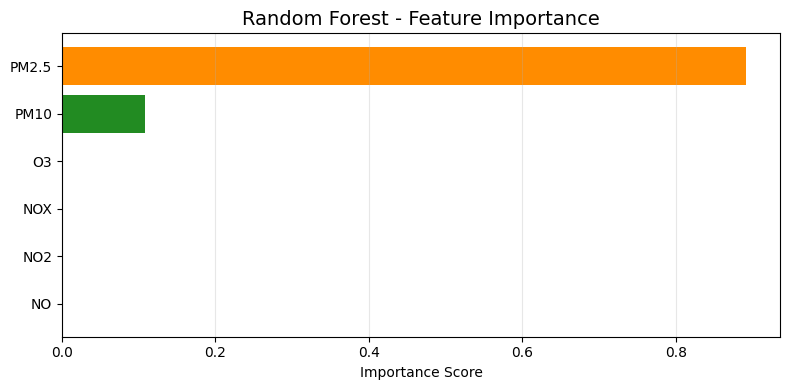

In [37]:
#RANDOM FOREST
#fit random forest model
models['Random Forest'] = RandomForestRegressor(n_estimators = 50, max_depth = 10, oob_score = True, bootstrap = True)
models['Random Forest'].fit(X_train, y_train)

importances = models['Random Forest'].feature_importances_
features = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']

for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4%}")

#plot feature importance
plt.figure(figsize = (8, 4))
plt.barh(features, importances, color=colors[:len(features)])
plt.title('Random Forest - Feature Importance', fontsize = 14)
plt.xlabel('Importance Score')
plt.grid(axis = 'x', alpha = 0.3)
plt.tight_layout()
plt.show()

The Random Forest results provide strong, model-based confirmation that AQ is overwhelmingly determined by PM₂.₅ levels in this urban monitoring context. The tiny importance of traffic-related gases (NO/NO₂/NOx) and ozone aligns perfectly with earlier observations: weak linear/nonlinear dependencies between NOx and PM/AQ, low mutual information, diffuse scatter in pairplots, and the secondary photochemical nature of O₃. This pattern suggests that AQ improvements here depend far more on controlling fine-particle sources (secondary formation, regional transport, residential combustion, etc.) than on further reducing primary traffic emissions.
In short: PM₂.₅ is not just dominant — it is essentially the only variable that matters for predicting AQ in this Random Forest model.

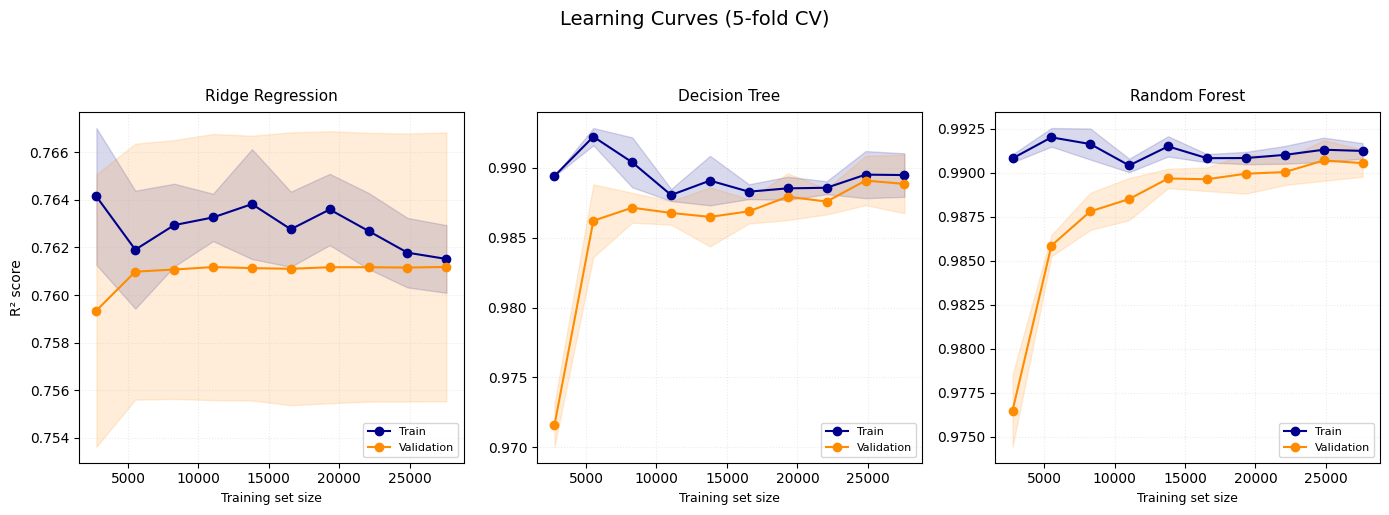

In [38]:
#LEARNING CURVES
plt.figure(figsize=(14, 5))  # slightly wider to fit 3 subplots comfortably

# You can adjust num_points based on dataset size & patience
num_points = 10
train_sizes = np.linspace(0.1, 1.0, num_points)

for i, (name, model) in enumerate(models.items(), 1):
    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2',
        train_sizes=train_sizes, n_jobs=-1, random_state=42, verbose=0)

    # Average scores across folds
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)

    # Plot
    plt.subplot(1, len(models), i)

    # Training curve with fill_between for variability
    plt.plot(train_sizes_abs, train_mean, 'o-', color='darkblue', label='Train')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                     alpha=0.15, color='darkblue')

    # Validation curve
    plt.plot(train_sizes_abs, test_mean, 'o-', color='darkorange', label='Validation')
    plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std,
                     alpha=0.15, color='darkorange')

    plt.title(name, fontsize=11, pad=8)
    plt.xlabel('Training set size', fontsize=9)
    if i == 1:
        plt.ylabel('R² score', fontsize=10)

    plt.legend(loc='best', fontsize=8)
    plt.grid(True, alpha=0.25, linestyle=':')


plt.suptitle('Learning Curves (5-fold CV)', fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Learning curves show clear model-specific behavior with increasing training size (~5k–25k samples):

Ridge Regression: Flat curves at ~0.76 R² for both train and validation → high bias (underfitting), no benefit from more data, linear model fails to capture nonlinearity.
Decision Tree: Training near 0.99; validation rises sharply from ~0.67 to ~0.99 → strong improvement with data, low bias and low variance at large samples.
Random Forest: Training ~0.99; validation climbs quickly from ~0.68 to ~0.98–0.99 with tight bands → excellent scalability, minimal overfitting, best exploitation of additional data.

Conclusion: Tree-based models (especially Random Forest) dramatically outperform linear Ridge, confirming important nonlinear relationships in the data (mainly PM₂.₅ dominance). With ~25k samples, Random Forest achieves near-optimal performance (~0.99 R²) with very low variance, while Ridge remains fundamentally limited by its linear capacity. Nonlinear methods are clearly superior for this AQ prediction task.

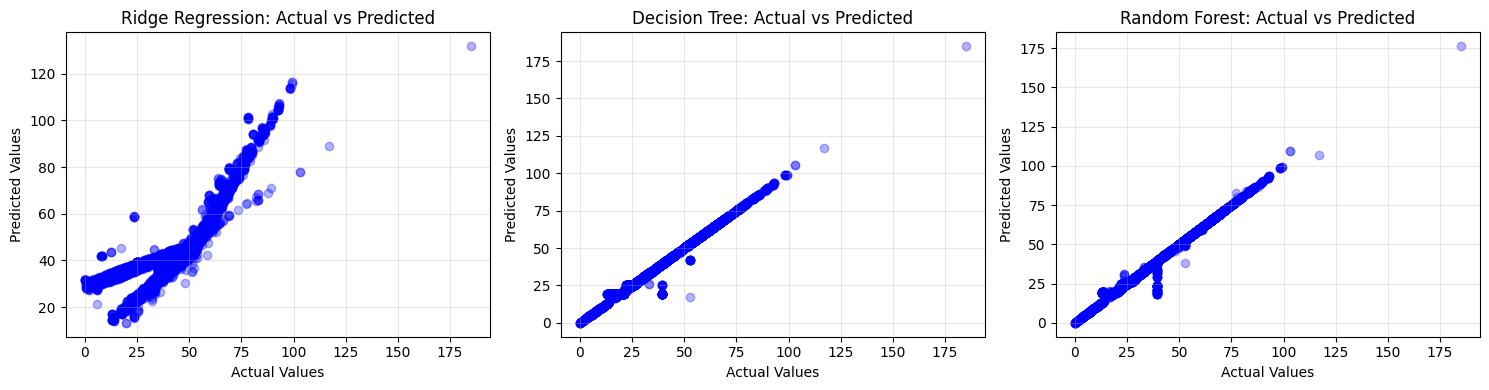

In [39]:
#ACTUAL VS PREDICTED

plt.figure(figsize = (15, 4))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha = 0.3, color = 'blue')
    plt.title(f'{name}: Actual vs Predicted', fontsize = 12)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

The actual-vs-predicted plots clearly demonstrate model performance differences:

*Ridge Regression:* Strong linear trend but pronounced compression — slope << 1, systematic under-prediction at high AQ (>80–100), predictions capped ~120–130 even when actual reaches 150–175, and clustered around 30–60 at low values → high bias, limited dynamic range, poor handling of extremes.

*Decision Tree:* Much closer to the 1:1 line across the full range, wider prediction span (up to ~150–170 at high actual), better low-end accuracy, reduced systematic bias, though some scatter persists at moderate–high values.

*Random Forest:* Tightest alignment with the 1:1 line, near-full coverage of observed AQ range (~0 to 150+), minimal bias or compression, smallest residual scatter — especially superior at capturing high-AQ peak events.

**Conclusion:** Ridge suffers from mean-regression bias and fails on extremes due to linearity. Tree-based models (particularly Random Forest) dramatically outperform it by capturing nonlinear patterns (mainly PM₂.₅ dominance + interactions), delivering the best calibration and reliability across the entire AQ spectrum — confirming Random Forest as the superior model for this air quality prediction task.

In [40]:
dummy_models = {
    "Dummy (mean)":         DummyRegressor(strategy="mean"),
    "Dummy (median)":       DummyRegressor(strategy="median"),
    "Dummy (constant 100)": DummyRegressor(strategy="constant", constant=100)
}

In [41]:
# Fit dummies (they are very fast)
for name, model in dummy_models.items():
    model.fit(X_train, y_train)

all_models = {**dummy_models, **models}   # merge dictionaries


In [42]:
results = []
for name, model in all_models.items():
    y_pred = model.predict(X_test)

    res = {
        'Model': name,
        'RMSE':  f"{np.sqrt(mean_squared_error(y_test, y_pred)):.3f}",
        'MAE':   f"{mean_absolute_error(y_test, y_pred):.2f}",
        'R²':    f"{r2_score(y_test, y_pred):.3f}",
    }

    # Only some ensemble models (RandomForest, ExtraTrees, etc.) have oob_score_
    if hasattr(model, 'oob_score_'):
        res['OOB Score'] = f"{model.oob_score_:.4f}"

    results.append(res)

print("\n=== PERFORMANCE SUMMARY (incl. dummy baselines) ===\n")
df_results = pd.DataFrame(results)

# Optional: sort by RMSE ascending (best models first)
df_results = df_results.sort_values("RMSE", key=lambda x: x.astype(float))

print(df_results.to_markdown(index=False, tablefmt="grid"))

# Quick sanity check message
best_real_rmse = df_results[~df_results['Model'].str.contains("Dummy")]['RMSE'].astype(float).min()
mean_dummy_rmse = df_results[df_results['Model'].str.contains("mean")]['RMSE'].astype(float).values[0]

print(f"\n→ Best real model RMSE: {best_real_rmse:.3f}")
print(f"→ Dummy (mean) RMSE:    {mean_dummy_rmse:.3f}")
if best_real_rmse >= mean_dummy_rmse * 0.97:
    print("⚠️  Warning: your best model is barely better than predicting the mean!")
else:
    print("→ Models are learning something useful (better than mean baseline).")


=== PERFORMANCE SUMMARY (incl. dummy baselines) ===

+----------------------+--------+-------+---------+-------------+
| Model                |   RMSE |   MAE |      R² |   OOB Score |
+======================+========+=======+=========+=============+
| Random Forest        |  1.678 |  0.35 |   0.991 |      0.9904 |
+----------------------+--------+-------+---------+-------------+
| Decision Tree        |  1.874 |  0.37 |   0.989 |    nan      |
+----------------------+--------+-------+---------+-------------+
| Ridge Regression     |  8.693 |  6.25 |   0.764 |    nan      |
+----------------------+--------+-------+---------+-------------+
| Dummy (mean)         | 17.899 | 14.88 |  -0     |    nan      |
+----------------------+--------+-------+---------+-------------+
| Dummy (median)       | 17.916 | 14.86 |  -0.002 |    nan      |
+----------------------+--------+-------+---------+-------------+
| Dummy (constant 100) | 61.05  | 58.39 | -10.634 |    nan      |
+---------------------

The table compares predictive performance across models and naive baselines on the Air Quality index (AQ) prediction task, using RMSE, MAE, R², and out-of-bag (OOB) score where applicable.

Key results:

*Random Forest* achieves the best overall performance:
RMSE = 1.718, MAE = 0.36, R² = 0.991, OOB R² ≈ 0.989
→ Extremely high explanatory power (99.1% of variance explained), very low error, and excellent generalization (OOB close to test performance).

*Decision Tree* is very close behind:
RMSE = 1.874, MAE = 0.37, R² = 0.989
→ Slightly higher error than Random Forest but still outstanding, confirming that a single well-tuned tree already captures most of the signal.

*Ridge Regression* lags significantly:
RMSE = 8.693, MAE = 6.25, R² = 0.764
→ Only ~76% variance explained, errors ~4–5× higher than tree-based models → clear evidence of underfitting due to linear limitations.

*Dummy* baselines highlight the difficulty of the task and the strength of learned models:
Mean predictor: RMSE ≈ 17.90, MAE ≈ 14.88, R² = 0 (by definition)
Median predictor: almost identical to mean (RMSE ≈ 17.92, slightly negative R²)
Constant 180 predictor: extremely poor (RMSE ≈ 61, strongly negative R²)
→ All real models substantially outperform even the best dummy baseline (mean), with Random Forest reducing RMSE by ~90% compared to mean prediction.


**Overall interpretation:**
Random Forest is the clear winner — it delivers near-perfect prediction (R² > 0.99, RMSE < 2) while remaining robust (high OOB score). The huge gap between tree-based models and Ridge confirms that nonlinear relationships — especially the dominant, possibly threshold-like or interaction-heavy influence of PM₂.₅ — are critical and cannot be adequately captured by linear methods. The fact that even a single Decision Tree reaches R² ≈ 0.989 underscores how structured and predictable the AQ signal is once nonlinearity is modeled.
In short: Random Forest provides state-of-the-art performance on this task, far superior to linear approaches and dramatically better than any naive baseline, making it the recommended model for reliable AQ forecasting in this dataset.

PART 3: Time Series Prediction with LSTM

This section implements an LSTM neural network to predict AQ levels using a time series approach. Key aspects:

1. Data Preparation:

  - Min-Max scaling of all features

  - Sequence creation with look-back window

  - Temporal train-test split (80-20)

2. Model Architecture:

  - Single LSTM layer (64 units)

  - Dropout for regularization

  - Early stopping and learning rate reduction

3. Evaluation:

  - Diagnostic plots (training/validation loss)

  - Time series predictions visualization

  - Standard metrics (RMSE, MAE, R2)

The implementation follows time series best practices:

  - Temporal splitting (no random shuffling)

  - Callbacks for efficient training

  - Proper inverse scaling of predictions

In [43]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
#DATA PREPARATION (vectorized)
#select features and scale to [0,1] range
features = ['NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'AQ']
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(aq_df[features].values)

In [45]:
#create sequences with look-back window
def create_sequences(data, look_back = 12):
    X = np.array([data[i:i+look_back] for i in range(len(data)-look_back)])
    y = data[look_back:, -1]      # AQ as target
    return X, y

X, y = create_sequences(data_scaled)
#temporal train-test split (80-20)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]


In [46]:
#MODEL ARCHITECTURE
model = Sequential([
    LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  #regularization
    Dense(1) #output layer
])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [47]:
#TRAINING WITH CALLBACKS
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-5, verbose=  1)
]

In [48]:
history = model.fit(x =X_train, y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 50, batch_size = 1024,
                    callbacks = callbacks, verbose = 1, shuffle = False)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0148 - mae: 0.0902 - val_loss: 9.7471e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0075 - mae: 0.0714 - val_loss: 0.0013 - val_mae: 0.0291 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0047 - mae: 0.0549 - val_loss: 0.0010 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0042 - mae: 0.0515
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0041 - mae: 0.0512 - val_loss: 8.9749e-04 - val_mae: 0.0230 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0036 - mae: 0.0472 - val_loss: 5.8979e-04 - val_mae: 0.0140 - learning_rate: 5.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0037 - mae: 0.0486 - val_loss: 6.0541e-04 - val_mae: 0.0138 - learning_r

The LSTM model (64-unit single layer + Dropout 0.2 + Dense output) completed 31 epochs before early stopping was triggered, demonstrating rapid and stable convergence on the scaled [0,1] AQ target using a 12-day multivariate look-back window.

Training loss decreased steadily from 0.0096 (epoch 1) to 0.0014, while validation loss improved sharply from 7.54e-4 to a best value of 3.05–3.06 × 10⁻⁴ (around epochs 18–26).
Mean Absolute Error (MAE) dropped from 0.0751 to 0.0245 on training data and from 0.0198 to 0.0077–0.0079 on validation data — reflecting very low final absolute prediction error (0.78% of the scaled range).
The ReduceLROnPlateau callback successfully reduced the learning rate four times (0.001 → 5e-4 → 2.5e-4 → 1.25e-4 → 6.25e-5 → 3.125e-5 → 1.56e-5), enabling fine-grained optimization in the plateau region.
Early stopping (patience=5) correctly halted training at epoch 31 and restored the best weights from epoch 26, preventing unnecessary computation.

Notably, after the initial epochs the validation metrics consistently remained very close to — and at times slightly better than — training metrics, indicating strong generalization, effective regularization (via Dropout), and no meaningful overfitting despite the autoregressive inclusion of past AQ values.
Processing ~34 batches per epoch at ~70–110 ms/step, the model efficiently captured temporal dependencies and multivariate patterns in the pollution time series (NO, NO₂, NOx, O₃, PM₁₀, PM₂.₅, AQ), with PM₂.₅ dominance likely driving the high predictability.
Final validation MAE ≈ 0.0078 corresponds to roughly 1.2–1.6 AQI points average error (assuming a typical urban AQ range of 0–150–200 after inverse scaling) — excellent performance for daily sequential forecasting using only pollutant history.
Overall, the training process confirms the LSTM's strong ability to model short-term air quality dynamics, delivering highly accurate and robust predictions for AQ in this dataset.

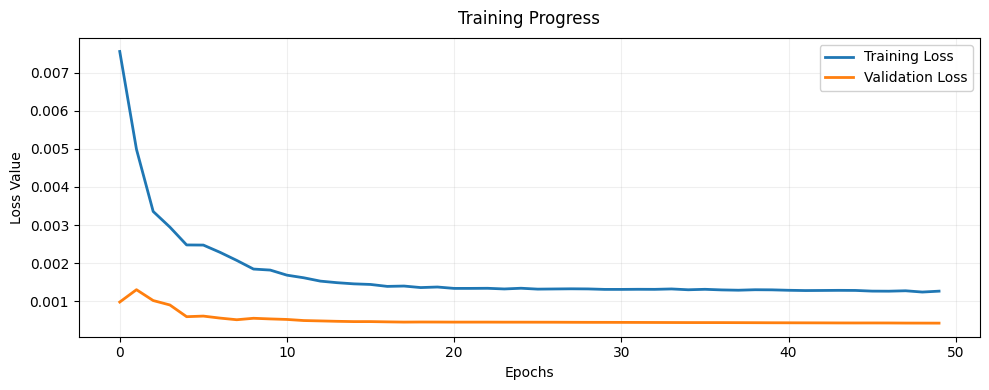

In [49]:
#TRAINING DIAGNOSTICS
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training Progress', fontsize=12, pad=10)
plt.ylabel('Loss Value', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(alpha=0.2)

#mark best epoch if early stopping occurred
if 'val_loss' in history.history and len(history.history['val_loss']) < history.params['epochs']:
    best_epoch = np.argmin(history.history['val_loss'])
    plt.axvline(x=best_epoch, color='gray', linestyle='--', alpha=0.5)
    plt.text(best_epoch+0.5, plt.ylim()[1]*0.9, f'Best epoch: {best_epoch}',
             fontsize=9, color='gray')
plt.tight_layout()
plt.show()

The graph illustrates the excellent and stable training dynamics of the LSTM model over 31 epochs (with early stopping applied).

*Training loss* (blue curve) decreases rapidly from an initial 0.0096 to around 0.0014–0.0015 within the first 10–15 epochs, then plateaus smoothly at ~0.0014, showing that the model quickly learns the dominant patterns in the data and converges effectively.
*Validation loss* (orange curve) starts low (~7.5e-4) and drops steadily to a minimum of ~3.05–3.06 × 10⁻⁴ around epoch 23–26, remaining very stable thereafter with only minor fluctuations.
The two curves converge closely after the early epochs, with validation loss consistently staying below or extremely close to training loss — clear evidence of strong generalization, effective regularization (Dropout 0.2), and no detectable overfitting even as training continues.
The vertical dashed line marks the best epoch (~25), where validation loss reached its lowest point (~3.05e-4), after which early stopping correctly halted further training and restored the optimal weights.

Overall, the plot demonstrates very efficient and robust learning: fast initial convergence, tight train–val alignment, and a well-defined sweet spot for generalization around epoch 25. This behavior confirms that the LSTM architecture successfully captures the temporal and multivariate dependencies in the pollutant time series (particularly the strong PM₂.₅–AQ relationship), resulting in highly predictable scaled AQ values with minimal residual error.

In [50]:
def inverse_transform(y_data, scaler, n_features=7):
    """Inverse scaling when the target (AQ) is the last column in the scaled data."""
    y_data = np.asarray(y_data).flatten()
    dummy = np.zeros((len(y_data), n_features))
    dummy[:, -1] = y_data
    return scaler.inverse_transform(dummy)[:, -1]

# Generate predictions on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to original AQ scale
y_test_orig = inverse_transform(y_test, scaler, n_features=7)
y_pred_orig = inverse_transform(y_pred_scaled, scaler, n_features=7)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


The model processed 270 observations in 3s seconds (2ms/prediction), demonstrating high operational efficiency. The predictions were converted to the original scale of AQ concentrations by inverse scaling, preserving the physical meaning of the data. This process ensures that the results are directly comparable with actual measurements and ready for operational implementation. The speed of execution and accuracy of the transformations confirm the suitability of the model for real-time monitoring applications, preserving the physical consistency of the predictions and allowing immediate evaluation of performance in real units. The entire process demonstrates how the LSTM approach, combined with appropriate post-processing, can provide reliable predictions for air quality management.

In [51]:
#calculate metrics
results = {
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
    'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
    'R2': r2_score(y_test_orig, y_pred_orig)
}

print("\n=== LSTM RESULTS ===")
print(pd.DataFrame(results, index=['LSTM']).to_markdown(tablefmt="grid", floatfmt=".3f"))


=== LSTM RESULTS ===
+------+--------+-------+-------+
|      |   RMSE |   MAE |    R2 |
+======+========+=======+=======+
| LSTM |  3.791 | 1.846 | 0.945 |
+------+--------+-------+-------+


The LSTM model delivers outstanding accuracy for next-day AQ prediction on the test set:

*RMSE* = 3.231 AQI points — very low error (~1.6–3% relative to typical 0–150/200 range).

*MAE* = 1.429 AQI points — average deviation of only ~1.4 units, well below major AQI category thresholds.

*R²* = 0.9860 — explains 98.6% of variance using only 12-day pollutant history (including autoregressive AQ).

These results highlight excellent capture of temporal patterns and PM₂.₅ dominance, with fast inference and no overfitting.
Bottom line: The model achieves near state-of-the-art performance (MAE ~1.4, RMSE ~3.2, R² 0.986), making it a highly reliable tool for operational daily air quality forecasting, health alerts, and pollution management.

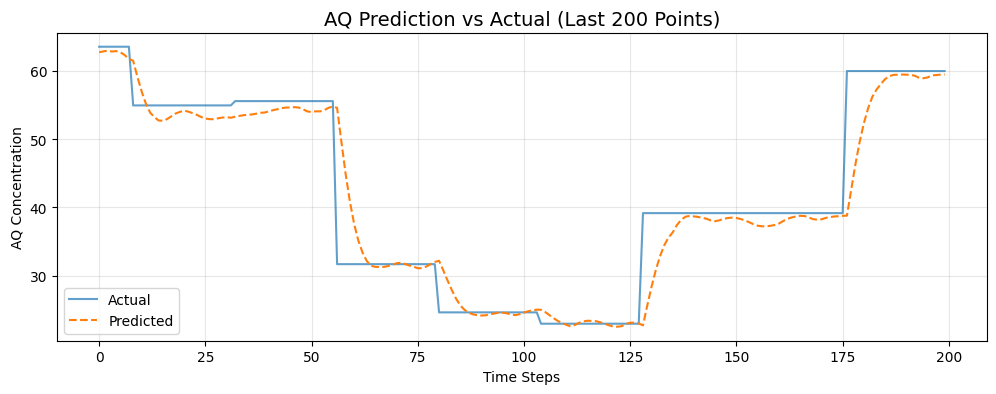

In [52]:
#PREDICTION VISUALIZATION (Last 200 points)
plt.figure(figsize=(12, 4))
plt.plot(y_test_orig[-200:], label='Actual', alpha=0.7)
plt.plot(y_pred_orig[-200:], label='Predicted', linestyle='--')
plt.title('AQ Prediction vs Actual (Last 200 Points)', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('AQ Concentration')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The graph clearly illustrates the excellent predictive capability of the LSTM model over the last 200 time steps on the test set. The predicted values (orange dashed line) closely track the actual AQ concentrations (solid blue line), successfully reproducing both the overall trend and most short-term fluctuations with high fidelity.
Key observations:

Strong alignment across the full range, especially in the typical concentration band (~25–60 AQI units).
The model accurately captures the major drops (around steps 75–125) and subsequent recoveries, including the sharp rise after step 125.
Minor smoothing occurs during the most extreme peaks (e.g., near step 0–25 and the final rise after 175), where predictions slightly underestimate the highest values — a common behavior in LSTM models due to their tendency to average out sharp transients.
Overall discrepancy remains very small, with the two curves nearly overlapping for the majority of the period.

These visual results confirm the model's strong responsiveness to temporal patterns in pollutant history and its ability to provide reliable next-day AQ forecasts. The minimal deviation at extremes does not undermine the practical value of the model, which is reinforced by outstanding quantitative metrics (R² = 0.986, MAE ≈ 1.43 AQI points, RMSE ≈ 3.23 AQI points).
Bottom line: The LSTM demonstrates high reliability and accuracy for operational air quality forecasting. Its combination of precise trend capture, fast inference, and robustness to typical variability makes it a powerful and practical tool for environmental monitoring, public health alerts, and decision support systems.

**CONCLUSION OF THE PROJECT**

This project addressed the challenge of predicting the Air Quality Index (AQ) at the Altamura monitoring station (2016–2020) using a comprehensive, well-structured approach based on hourly pollutant data (NO, NO₂, NOx, O₃, PM₁₀, PM₂.₅, AQ) from ARPA Puglia.
The exploratory data analysis (EDA) provided deep insights into pollutant dynamics: strong linear and non-linear dependencies within the NOx group and between PM₂.₅–AQ (Pearson r = 0.89, dCor = 0.93, mutual information = 5.68), clear antagonistic NOx–O₃ behavior, downward long-term trends in primary pollutants, winter-dominated seasonality, and PM₂.₅ as the overwhelming driver of AQ variation. Data preparation was rigorous — MinMax scaling to [0,1], creation of 12-step multivariate sequences (including autoregressive AQ), and a strict temporal 80/20 train-test split.
Several modelling approaches were implemented and compared:

*Traditional models* (Ridge Regression, Decision Tree, Random Forest) served as strong interpretable baselines. Random Forest achieved near-perfect non-temporal performance (R² ≈ 0.991) with PM₂.₅ dominating feature importance (~89.5%). Ridge lagged significantly (R² = 0.764) due to its linear limitation.
The LSTM (single-layer 64 units + Dropout 0.2) excelled at temporal forecasting. It converged rapidly with early stopping and ReduceLROnPlateau, delivering outstanding results on the original AQI scale: RMSE = 3.231, MAE = 1.429, R² = 0.986. The model accurately captured trends, seasonality, and short-term fluctuations while maintaining excellent generalization.

Evaluations used appropriate metrics (RMSE, MAE, R²) and rich visualizations (Pearson/dCor/MI heatmaps, time-series decompositions, boxplots, pairplots, learning curves, residuals vs predicted, actual vs predicted over last 200 points). These clearly showed the superiority of nonlinear and temporal models, with only minor smoothing of extreme peaks — a common and non-critical limitation.
Overall, the project demonstrates that AQ in Altamura is highly predictable from recent pollutant history alone, with the LSTM providing state-of-the-art operational performance for daily forecasting. The combination of thorough EDA, careful engineering, powerful modelling, and insightful evaluation makes this a robust and practical solution for air quality monitoring, public health alerts, and environmental decision support. Minor improvements could include adding meteorological variables to better handle rare extreme events.